# Use Case: Credit Scoring using Lending Club Loan Data

### Dataset: Lending Club Loan Data at Kaggle.com   
* https://www.kaggle.com/wordsforthewise/lending-club    

In [1]:
options(scipen=999)
options(warn=-1)
suppressWarnings(suppressPackageStartupMessages({
  library(data.table)
  library(funModeling)
  library(sqldf)
  library(readxl)
  library(dplyr)
  library(DescTools)
  library(usmap)
}))

### Get the data

In [2]:
dt <- fread("data/accepted_2007_to_2018Q4.csv.gz",showProgress=FALSE,na.strings="")

In [3]:
# # sampling
# library(dplyr)
# set.seed(1)
# dt <- dt %>%
#   group_by(loan_status) %>%
#   sample_frac(0.1)

### Describe the Dataset

In [4]:
# Print dimensions: Rows, Columns
dim(dt)

[1] 2260701     151

In [5]:
# Load variable descriptions from Data Dictionary 
data_dictionary <- read_excel("data/LCDataDictionary.xlsx")

dt_status <- df_status(dt,print_results=F)
dt_status <- sqldf("select Description description, dt_status.* 
                   from dt_status
                   left join data_dictionary 
                   on variable=LoanStatNew")
dt_status

description,variable,q_zeros,p_zeros,q_na,p_na,q_inf,p_inf,type,unique
<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<fct>,<int>
A unique LC assigned ID for the loan listing.,id,0,0.00,0,0.00,0,0,character,2260701
A unique LC assigned Id for the borrower member.,member_id,0,0.00,2260701,100.00,0,0,logical,0
"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",loan_amnt,0,0.00,33,0.00,0,0,numeric,1572
The total amount committed to that loan at that point in time.,funded_amnt,0,0.00,33,0.00,0,0,numeric,1572
The total amount committed by investors for that loan at that point in time.,funded_amnt_inv,233,0.01,33,0.00,0,0,numeric,10057
The number of payments on the loan. Values are in months and can be either 36 or 60.,term,0,0.00,33,0.00,0,0,character,2
Interest Rate on the loan,int_rate,0,0.00,33,0.00,0,0,numeric,673
The monthly payment owed by the borrower if the loan originates.,installment,0,0.00,33,0.00,0,0,numeric,93301
LC assigned loan grade,grade,0,0.00,33,0.00,0,0,character,7


### Variables: "issue_month", "issue_year"

In [6]:
dt$issue_month=substring(dt$issue_d,1,3)
dt$issue_year=substring(dt$issue_d,5)

In [7]:
# Review "loan_status"
sqldf("select loan_status, count(*),  100.0 * count(*) / (select count(*) from dt) pc
      from dt 
      group by loan_status order by 2 desc")

loan_status,count(*),pc
<chr>,<int>,<dbl>
Fully Paid,1076751,47.629076114
Current,878317,38.851533219
Charged Off,268559,11.879456859
Late (31-120 days),21467,0.949572721
In Grace Period,8436,0.373158591
Late (16-30 days),4349,0.192373958
Does not meet the credit policy. Status:Fully Paid,1988,0.087937326
Does not meet the credit policy. Status:Charged Off,761,0.033662125
Default,40,0.001769363


In [8]:
# Status for "bad" loans
bad_loan_status <- c("Charged Off",
                    "Default",
                    "Does not meet the credit policy. Status:Charged Off",
                    "In Grace Period", 
                    "Default Receiver", 
                    "Late (16-30 days)",
                    "Late (31-120 days)")

### Variable to be predicted: "loan_outcome"

In [9]:
# Assign certain statuses to a 'bad' ('1') loan_out_come 
dt$loan_outcome  <- as.factor(ifelse(dt$loan_status %in% bad_loan_status, 1,
                          ifelse(dt$loan_status=="", NA, 0)
                          ))

In [10]:
# Bad and good loans
sqldf("select loan_status, loan_outcome, count(*) count, 100.0 * count(*) / (select count(*) from dt) pc
        from dt 
        where loan_status>''
        group by loan_status 
        union
        select \"---- Subtotal ----\", loan_outcome, count(*) , 100.0 * count(*) / (select count(*) from dt)
        from dt 
        where loan_status>''
        group by loan_outcome 
        order by 2, 3 desc")

loan_status,loan_outcome,count,pc
<chr>,<fct>,<int>,<dbl>
---- Subtotal ----,0,1957056,86.568546659
Fully Paid,0,1076751,47.629076114
Current,0,878317,38.851533219
Does not meet the credit policy. Status:Fully Paid,0,1988,0.087937326
---- Subtotal ----,1,303612,13.429993617
Charged Off,1,268559,11.879456859
Late (31-120 days),1,21467,0.949572721
In Grace Period,1,8436,0.373158591
Late (16-30 days),1,4349,0.192373958


The dataset appears to be unbalanced with respect to the target variable "loan_outcome", where near 13% of the sample is marked as "bad".  
Working on credits that were "Fully Paid" and bad credits, not using loans with "Current" status, would make the dataset less unbalanced.  
It would also serve to work with credits that have completed their cycle or failed, whichever comes first.

In [11]:
# Remove rows where variable "loan_status" is "Current" or NULL
dt <-  dt[!(dt$loan_status == "Current" | is.na(dt$loan_status)),]

In [12]:
# Bad and good loans
sqldf("select loan_status, loan_outcome, count(*) count, 100.0 * count(*) / (select count(*) from dt) pc
        from dt 
        group by loan_status 
        union all
        select \"---- Subtotal ----\", loan_outcome, count(*) , 100.0 * count(*) / (select count(*) from dt)
        from dt 
        group by loan_outcome 
        order by 2, 3 desc")

loan_status,loan_outcome,count,pc
<chr>,<fct>,<int>,<dbl>
---- Subtotal ----,0,1078739,78.036547881
Fully Paid,0,1076751,77.892734913
Does not meet the credit policy. Status:Fully Paid,0,1988,0.143812968
---- Subtotal ----,1,303612,21.963452119
Charged Off,1,268559,19.427699622
Late (31-120 days),1,21467,1.552934096
In Grace Period,1,8436,0.610264687
Late (16-30 days),1,4349,0.314608952
Does not meet the credit policy. Status:Charged Off,1,761,0.055051141


The dataset is still unbalanced but the proportion of bad credits has risen to near 22%

In [13]:
# Bad credits by year
sqldf("select issue_year, count(*), avg(loan_outcome)
       from dt
       group by issue_year
       union 
       select '--- Total ---', count(*), avg(loan_outcome)
       from dt
       order by 1")

issue_year,count(*),avg(loan_outcome)
<chr>,<int>,<dbl>
--- Total ---,1382351,0.2196345
2007,603,0.2620232
2008,2393,0.2072712
2009,5281,0.1369059
2010,12537,0.1401452
2011,21721,0.1517886
2012,53367,0.1619728
2013,134808,0.1559848
2014,223710,0.1867105


It can be seen that the credits issued in 2007 and 2008 that already completed their cycle deteriorated 26% and 21% respectively. This may be due to the 2008 crisis.    
This does not repeat in the sample until 2015 and worsens in 2106, 2017 and 2018, averaging 22% deterioration.

As for the non-numeric variables, I will use those that have equal to or less than 100 instances, because I intend to encode the categorical variables using one-hot-encoding, so as not to have widely dispersed data. Special cases are the variable "id", which will not be encoded and the variable "issue_d" (issue date), of which the part of the month of the date will be used, in order to capture seasonality.

In [14]:
dt_status <- df_status(dt,print_results=FALSE)

In [15]:
# Not using variables with a lot of categories
vars_category2drop=sqldf("
  select variable from dt_status 
  where \"type\"='character' and \"unique\">60
  and variable not in ('id','issue_d')
")$variable
vars_category2drop

[1] "emp_title"                 "url"                      
 [3] "desc"                      "title"                    
 [5] "zip_code"                  "earliest_cr_line"         
 [7] "last_pymnt_d"              "next_pymnt_d"             
 [9] "last_credit_pull_d"        "sec_app_earliest_cr_line" 
[11] "debt_settlement_flag_date" "settlement_date"

Variables with constant values will be eliminated

In [16]:
# Eliminating variables with 1 unique values <=1
vars_unique=sqldf("select variable from dt_status where \"unique\"<=1")$variable
# vars_unique

Variables with more than 50% of missing values will be eliminated

In [17]:
# Variables with many nulls to drop
vars_with_many_nulls<-sqldf("select variable from dt_status where p_na>50")$variable
# vars_with_many_nulls

In [18]:
vars_2drop=append(vars_category2drop,vars_unique)
vars_2drop=append(vars_2drop,vars_with_many_nulls)
vars_2drop

[1] "emp_title"                                 
 [2] "url"                                       
 [3] "desc"                                      
 [4] "title"                                     
 [5] "zip_code"                                  
 [6] "earliest_cr_line"                          
 [7] "last_pymnt_d"                              
 [8] "next_pymnt_d"                              
 [9] "last_credit_pull_d"                        
[10] "sec_app_earliest_cr_line"                  
[11] "debt_settlement_flag_date"                 
[12] "settlement_date"                           
[13] "member_id"                                 
[14] "policy_code"                               
[15] "hardship_type"                             
[16] "deferral_term"                             
[17] "hardship_length"                           
[18] "member_id"                                 
[19] "desc"                                      
[20] "mths_since_last_delinq"                    
[21] "mths_since_last_record"                    
[22] "next_pymnt_d"                              
[23] "mths_since_last_major_derog"               
[24] "annual_inc_joint"                          
[25] "dti_joint"                                 
[26] "verification_status_joint"                 
[27] "open_acc_6m"                               
[28] "open_act_il"                               
[29] "open_il_12m"                               
[30] "open_il_24m"                               
[31] "mths_since_rcnt_il"                        
[32] "total_bal_il"                              
[33] "il_util"                                   
[34] "open_rv_12m"                               
[35] "open_rv_24m"                               
[36] "max_bal_bc"                                
[37] "all_util"                                  
[38] "inq_fi"                                    
[39] "total_cu_tl"                               
[40] "inq_last_12m"                              
[41] "mths_since_recent_bc_dlq"                  
[42] "mths_since_recent_revol_delinq"            
[43] "revol_bal_joint"                           
[44] "sec_app_fico_range_low"                    
[45] "sec_app_fico_range_high"                   
[46] "sec_app_earliest_cr_line"                  
[47] "sec_app_inq_last_6mths"                    
[48] "sec_app_mort_acc"                          
[49] "sec_app_open_acc"                          
[50] "sec_app_revol_util"                        
[51] "sec_app_open_act_il"                       
[52] "sec_app_num_rev_accts"                     
[53] "sec_app_chargeoff_within_12_mths"          
[54] "sec_app_collections_12_mths_ex_med"        
[55] "sec_app_mths_since_last_major_derog"       
[56] "hardship_type"                             
[57] "hardship_reason"                           
[58] "hardship_status"                           
[59] "deferral_term"                             
[60] "hardship_amount"                           
[61] "hardship_start_date"                       
[62] "hardship_end_date"                         
[63] "payment_plan_start_date"                   
[64] "hardship_length"                           
[65] "hardship_dpd"                              
[66] "hardship_loan_status"                      
[67] "orig_projected_additional_accrued_interest"
[68] "hardship_payoff_balance_amount"            
[69] "hardship_last_payment_amount"              
[70] "debt_settlement_flag_date"                 
[71] "settlement_status"                         
[72] "settlement_date"                           
[73] "settlement_amount"                         
[74] "settlement_percentage"                     
[75] "settlement_term"

In [19]:
# More variables to exclude

dt$loan_status=NULL           # Not used, grouped in "loan_outcome"
dt$issue_d=NULL               # Not used as date, just the "month" part to capture seasonality
dt$issue_year=NULL            # Not used as year, the model to build should be generalized for every year


In [20]:
# These variables do not appear to be part of lean origin. They are removed to avoid data leaking
dt$out_prncp_inv=NULL
dt$recoveries=NULL
dt$collection_recovery_fee=NULL
dt$acc_now_delinq=NULL
dt$num_tl_120dpd_2m=NULL
dt$pub_rec_bankruptcies=NULL
dt$hardship_flag=NULL
dt$debt_ssettlement_flag=NULL
dt$pymnt_plan=NULL
dt$collections_12_mths_ex_med=NULL
dt$total_rec_late_fee=NULL
dt$total_rec_prncp=NULL
dt$total_pymnt_inv=NULL
dt$total_pymnt=NULL
dt$out_prncp=NULL
dt$total_rec_int=NULL
#dt$pub_rec
#dt$inq_last_6mths
# LC grades
dt$grade=NULL
dt$sub_grade=NULL


In [21]:
vars=colnames(dt)
vars=setdiff(vars,vars_2drop)

In [22]:
dt=dt[,vars,with=FALSE]

In [23]:
dt_status <- df_status(dt,print_results=FALSE)
dt_status <- sqldf("select Description description, dt_status.* 
                   from dt_status
                   left join data_dictionary 
                   on variable=LoanStatNew")
dt_status

description,variable,q_zeros,p_zeros,q_na,p_na,q_inf,p_inf,type,unique
<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<fct>,<int>
A unique LC assigned ID for the loan listing.,id,0,0.00,0,0.00,0,0,character,1382351
"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",loan_amnt,0,0.00,0,0.00,0,0,numeric,1564
The total amount committed to that loan at that point in time.,funded_amnt,0,0.00,0,0.00,0,0,numeric,1564
The total amount committed by investors for that loan at that point in time.,funded_amnt_inv,233,0.02,0,0.00,0,0,numeric,10045
The number of payments on the loan. Values are in months and can be either 36 or 60.,term,0,0.00,0,0.00,0,0,character,2
Interest Rate on the loan,int_rate,0,0.00,0,0.00,0,0,numeric,672
The monthly payment owed by the borrower if the loan originates.,installment,0,0.00,0,0.00,0,0,numeric,84265
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.,emp_length,0,0.00,81437,5.89,0,0,character,11
"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER",home_ownership,0,0.00,0,0.00,0,0,character,6


## Univariate Plot & Analysis

------------------------------------------------------------------------------ 
dt$loan_amnt (numeric)

     length          n       NAs     unique         0s       mean     meanCI'
  1'382'351  1'382'351         0      1'564          0  14'477.70  14'463.11
                100.0%      0.0%                  0.0%             14'492.30
                                                                            
        .05        .10       .25     median        .75        .90        .95
   3'200.00   5'000.00  8'000.00  12'000.00  20'000.00  28'000.00  33'000.00
                                                                            
      range         sd     vcoef        mad        IQR       skew       kurt
  39'500.00   8'753.38      0.60   8'895.60  12'000.00       0.78      -0.09
                                                                            
lowest : 500.0 (11), 550.0, 600.0 (6), 700.0 (3), 725.0
highest: 39'900.0 (11), 39'925.0 (2), 39'950.0 (2), 39'975.0 (5), 40'

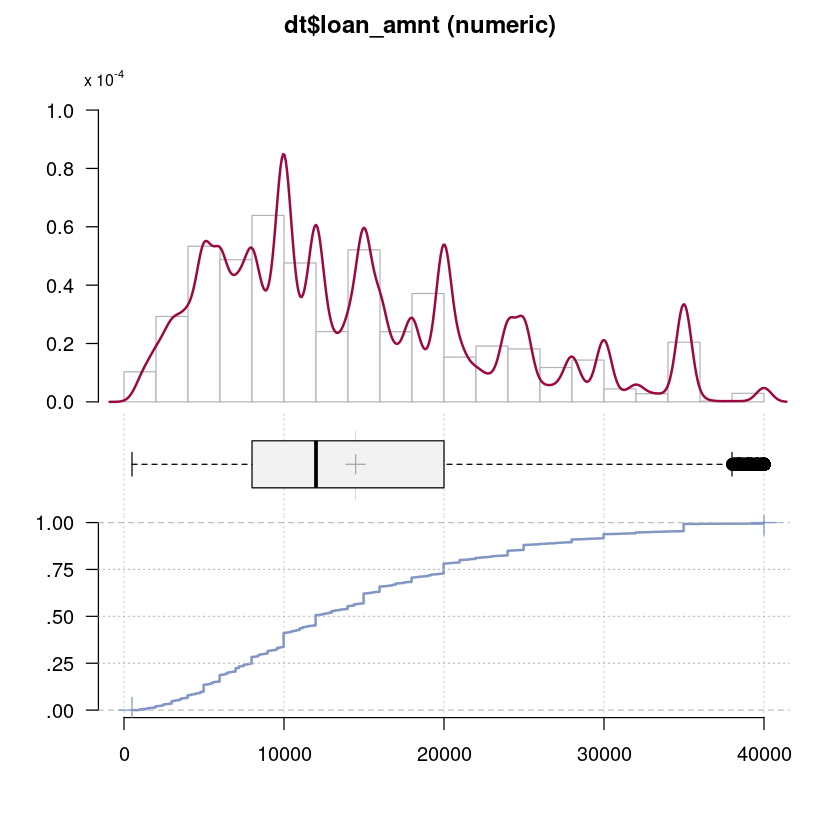

In [26]:
# loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
Desc(dt$loan_amnt, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$funded_amnt (numeric)

     length          n       NAs     unique         0s       mean     meanCI'
  1'382'351  1'382'351         0      1'564          0  14'469.11  14'454.53
                100.0%      0.0%                  0.0%             14'483.70
                                                                            
        .05        .10       .25     median        .75        .90        .95
   3'200.00   5'000.00  8'000.00  12'000.00  20'000.00  28'000.00  33'000.00
                                                                            
      range         sd     vcoef        mad        IQR       skew       kurt
  39'500.00   8'749.67      0.60   8'895.60  12'000.00       0.78      -0.09
                                                                            
lowest : 500.0 (11), 550.0, 600.0 (6), 700.0 (3), 725.0
highest: 39'900.0 (11), 39'925.0 (2), 39'950.0 (2), 39'975.0 (5), 4

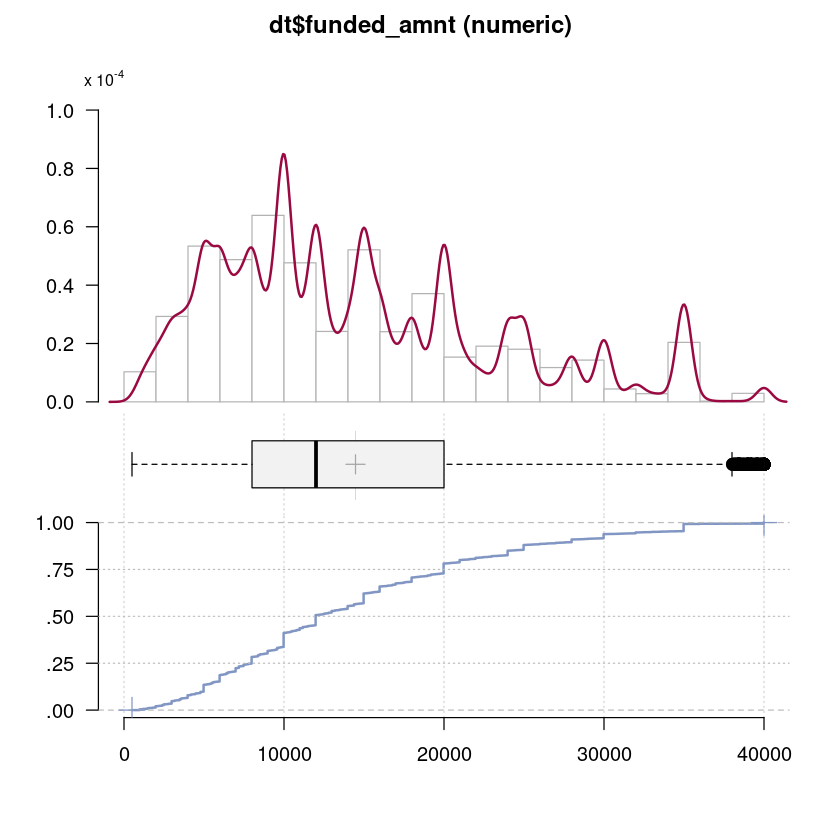

In [27]:
# funded_amnt : The total amount committed to that loan at that point in time.
Desc(dt$funded_amnt, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$funded_amnt_inv (numeric)

     length          n       NAs     unique         0s       mean     meanCI'
  1'382'351  1'382'351         0     10'045        233  14'442.02  14'427.43
                100.0%      0.0%                  0.0%             14'456.62
                                                                            
        .05        .10       .25     median        .75        .90        .95
   3'125.00   4'925.00  7'950.00  12'000.00  20'000.00  28'000.00  33'000.00
                                                                            
      range         sd     vcoef        mad        IQR       skew       kurt
  40'000.00   8'755.72      0.61   8'858.53  12'050.00       0.78      -0.09
                                                                            
lowest : 0.0 (233), 0.0, 0.0, 0.0, 0.0
highest: 39'900.0 (14), 39'925.0 (16), 39'950.0 (64), 39'975.0 (156), 40'000.0 (

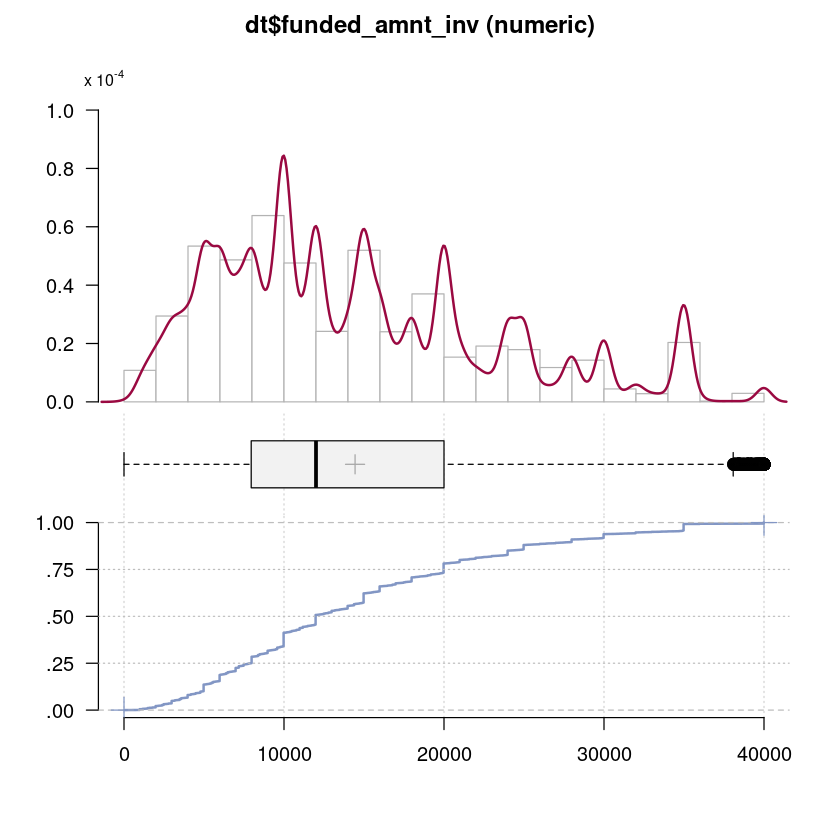

In [28]:
# funded_amnt_inv : The total amount committed by investors for that loan at that point in time.
Desc(dt$funded_amnt_inv, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$term (character - dichotomous)

     length         n       NAs    unique
  1'382'351 1'382'351         0         2
               100.0%      0.0%          

                freq   perc  lci.95  uci.95'
36 months  1'043'059  75.5%   75.4%   75.5%
60 months    339'292  24.5%   24.5%   24.6%

' 95%-CI (Wilson)


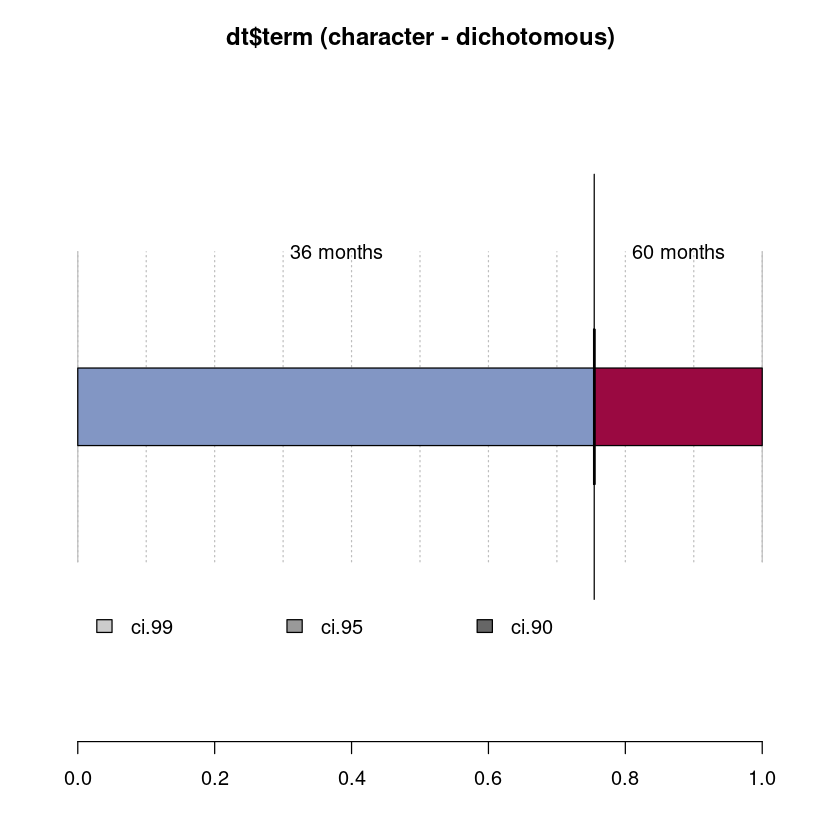

In [29]:
# term : The number of payments on the loan. Values are in months and can be either 36 or 60.
Desc(dt$term, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$int_rate (numeric)

     length          n    NAs  unique     0s   mean  meanCI'
  1'382'351  1'382'351      0     672      0  13.30   13.29
                100.0%   0.0%           0.0%          13.31
                                                           
        .05        .10    .25  median    .75    .90     .95
       6.62       7.49   9.75   12.79  16.02  19.52   22.35
                                                           
      range         sd  vcoef     mad    IQR   skew    kurt
      25.68       4.79   0.36    4.69   6.27   0.72    0.52
                                                           
lowest : 5.31 (944), 5.32 (28'985), 5.42 (573), 5.79 (410), 5.93 (1'812)
highest: 30.79 (874), 30.84 (503), 30.89 (454), 30.94 (496), 30.99 (547)

' 95%-CI (classic)


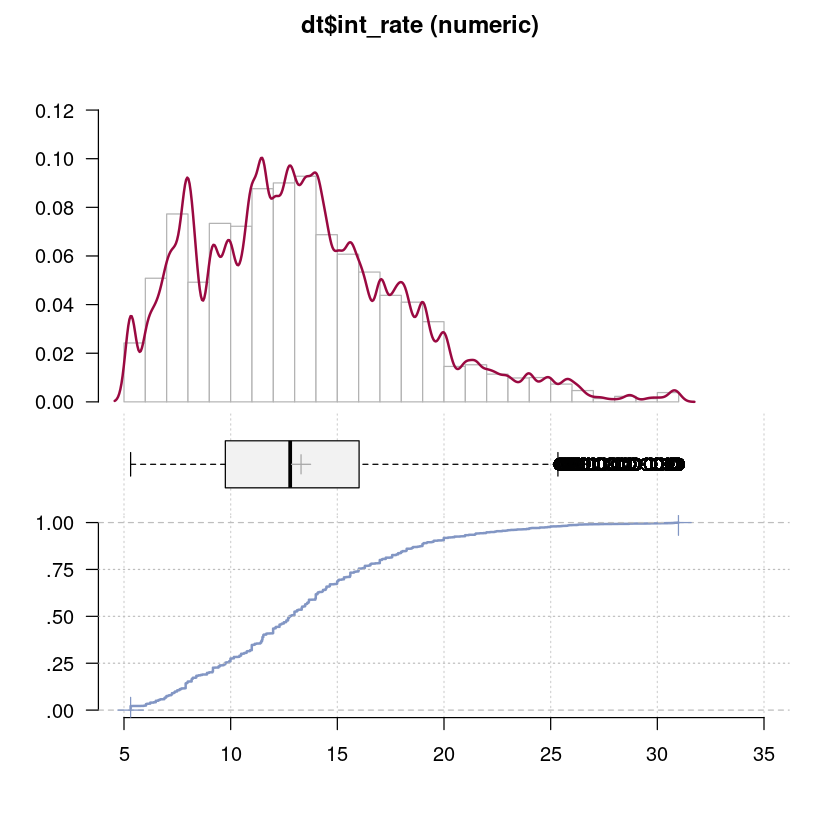

In [30]:
# int_rate : Interest Rate on the loan
Desc(dt$int_rate, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$installment (numeric)

     length          n     NAs  unique      0s    mean  meanCI'
  1'382'351  1'382'351       0  84'265       0  439.49  439.05
                100.0%    0.0%            0.0%          439.92
                                                              
        .05        .10     .25  median     .75     .90     .95
     108.89     158.04  249.18  375.54  582.62  811.62  966.27
                                                              
      range         sd   vcoef     mad     IQR    skew    kurt
   1'714.90     262.40    0.60  231.09  333.44    1.00    0.74
                                                              
lowest : 4.93, 7.61, 14.01, 14.77, 15.67
highest: 1'691.28 (2), 1'714.54 (4), 1'715.42 (2), 1'717.63, 1'719.83 (2)

' 95%-CI (classic)


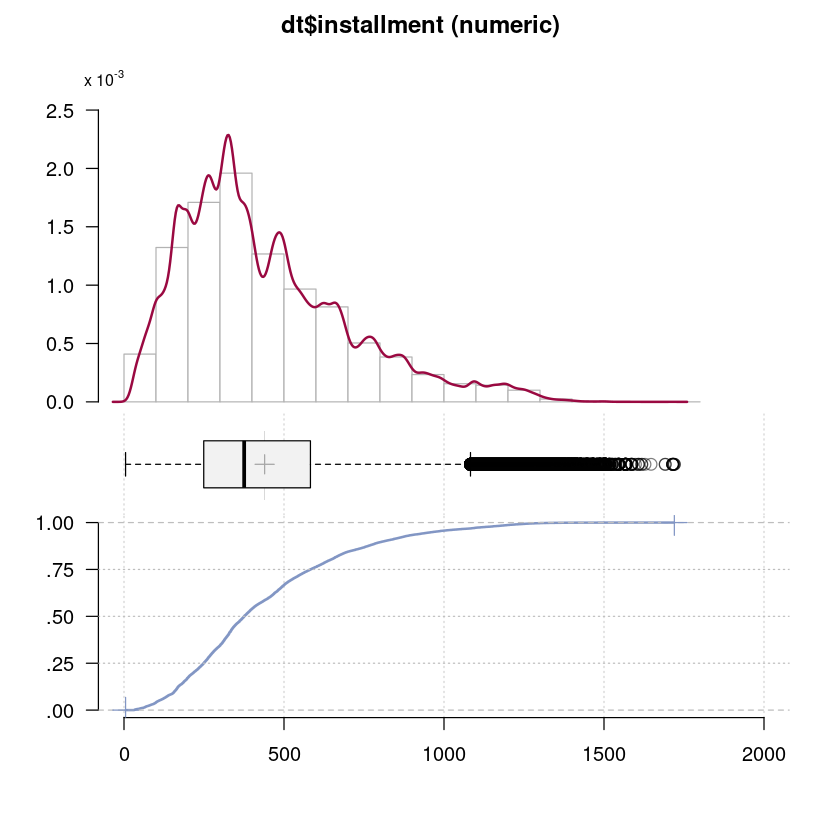

In [31]:
# installment : The monthly payment owed by the borrower if the loan originates.
Desc(dt$installment, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$emp_length (character)

     length         n       NAs    unique    levels     dupes
  1'382'351 1'300'914    81'437        11        11         y
                94.1%      5.9%                              

        level     freq   perc    cumfreq  cumperc
1   10+ years  453'281  34.8%    453'281    34.8%
2     2 years  125'246   9.6%    578'527    44.5%
3    < 1 year  111'768   8.6%    690'295    53.1%
4     3 years  110'684   8.5%    800'979    61.6%
5      1 year   91'130   7.0%    892'109    68.6%
6     5 years   86'452   6.6%    978'561    75.2%
7     4 years   82'975   6.4%  1'061'536    81.6%
8     6 years   64'377   4.9%  1'125'913    86.5%
9     8 years   62'043   4.8%  1'187'956    91.3%
10    7 years   60'927   4.7%  1'248'883    96.0%
11    9 years   52'031   4.0%  1'300'914   100.0%


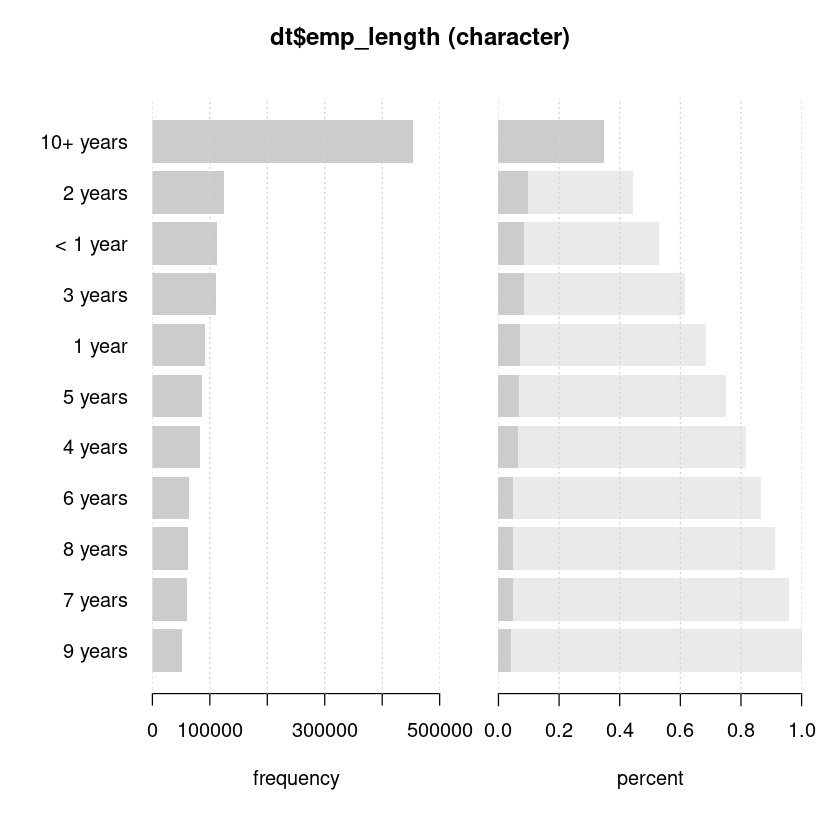

In [34]:
# emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
Desc(dt$emp_length, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$home_ownership (character)

     length         n       NAs    unique    levels     dupes
  1'382'351 1'382'351         0         6         6         y
               100.0%      0.0%                              

      level     freq   perc    cumfreq  cumperc
1  MORTGAGE  682'142  49.3%    682'142    49.3%
2      RENT  550'448  39.8%  1'232'590    89.2%
3       OWN  149'215  10.8%  1'381'805   100.0%
4       ANY      311   0.0%  1'382'116   100.0%
5     OTHER      182   0.0%  1'382'298   100.0%
6      NONE       53   0.0%  1'382'351   100.0%


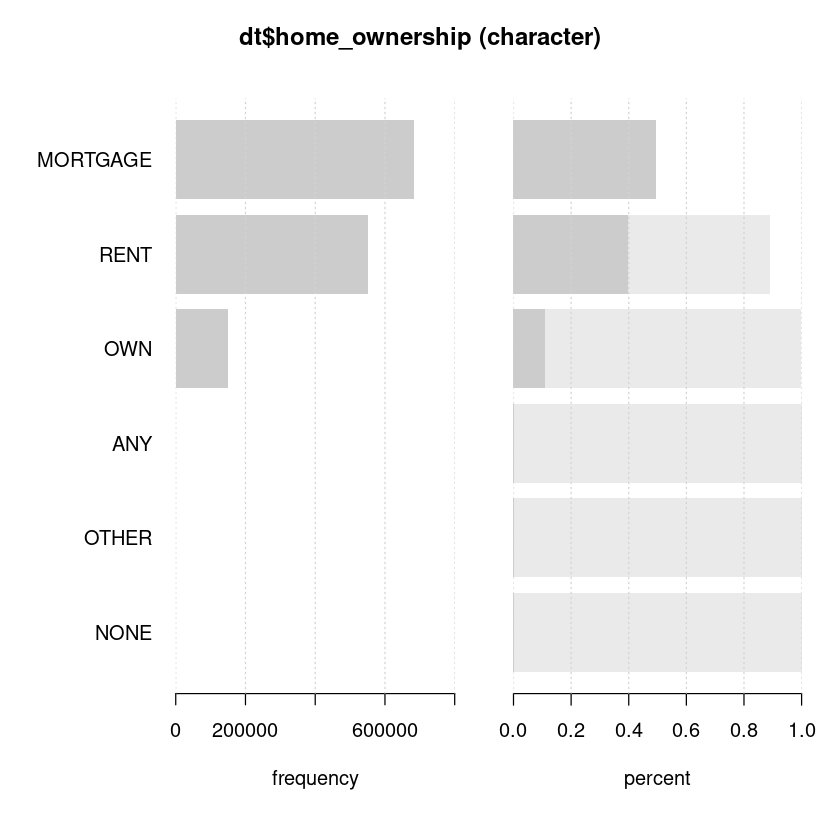

In [35]:
# home_ownership : The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
Desc(dt$home_ownership, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$annual_inc (numeric)

         length          n        NAs     unique         0s        mean'
      1'382'351  1'382'347          4     65'577        396   76'290.12
                    100.0%       0.0%                  0.0%            
                                                                       
            .05        .10        .25     median        .75         .90
      28'000.00  34'000.00  45'760.00  65'000.00  90'000.00  125'000.00
                                                                       
          range         sd      vcoef        mad        IQR        skew
  10'999'200.00  70'270.46       0.92  31'134.60  44'240.00       46.56
                                                                       
      meanCI
   76'172.98
   76'407.26
            
         .95
  155'000.00
            
        kurt
    4'848.94
            
lowest : 0.0 (396), 1.0 (15), 2.0, 16.0, 20.

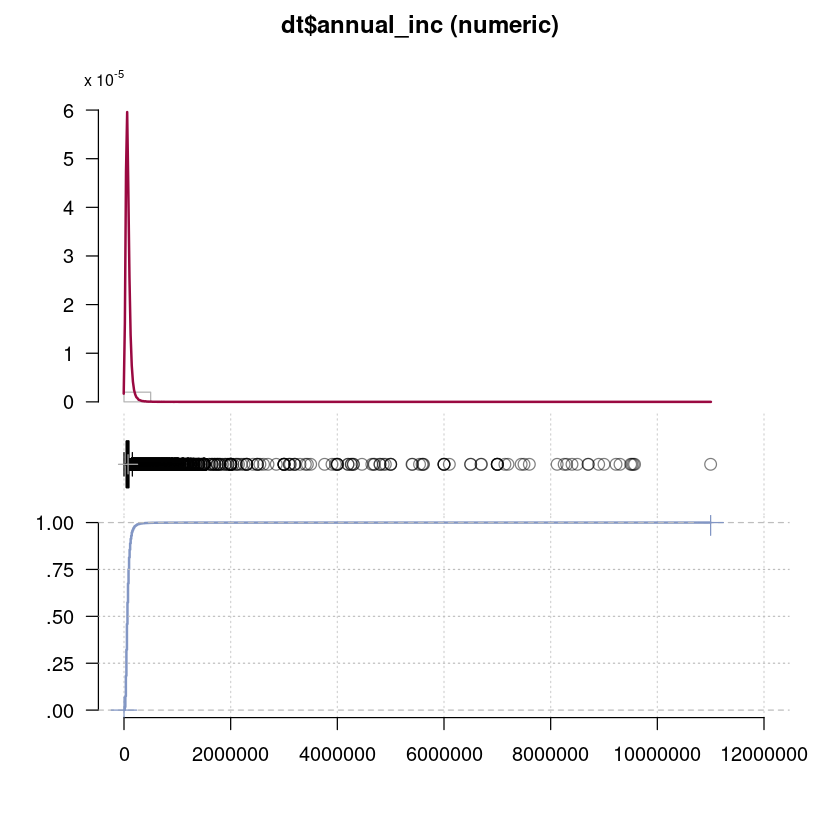

In [36]:
# annual_inc : The self-reported annual income provided by the borrower during registration.
Desc(dt$annual_inc, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$verification_status (character)

     length         n       NAs    unique    levels     dupes
  1'382'351 1'382'351         0         3         3         y
               100.0%      0.0%                              

             level     freq   perc    cumfreq  cumperc
1  Source Verified  536'031  38.8%    536'031    38.8%
2         Verified  429'617  31.1%    965'648    69.9%
3     Not Verified  416'703  30.1%  1'382'351   100.0%


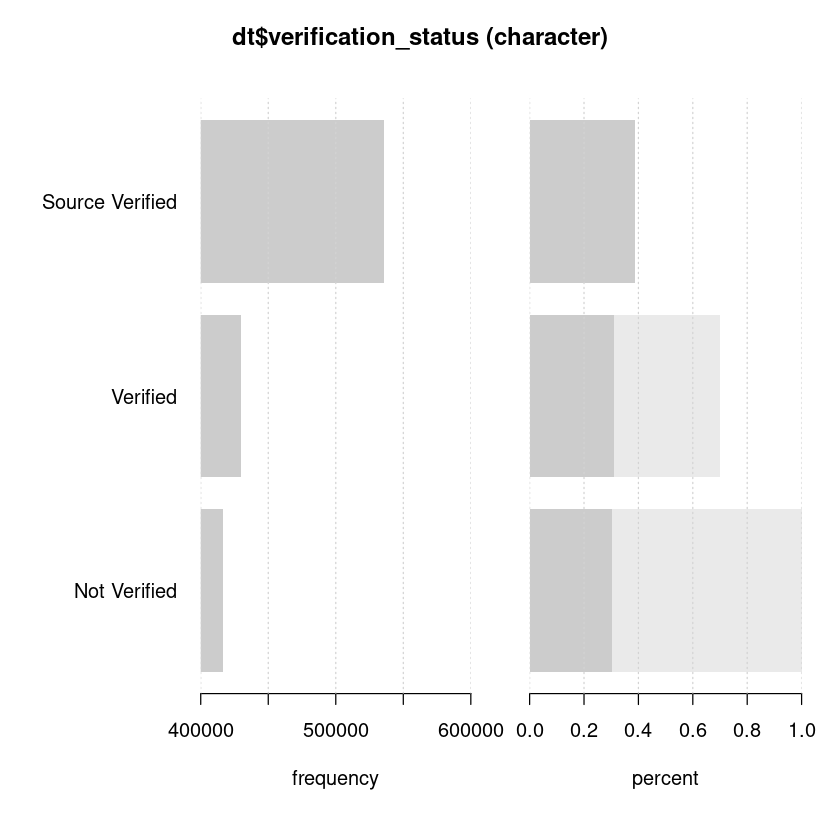

In [37]:
# verification_status : Indicates if income was verified by LC, not verified, or if the income source was verified
Desc(dt$verification_status, plotit = TRUE)

In [38]:
# pymnt_plan : Indicates if a payment plan has been put in place for the loan
# Desc(dt$pymnt_plan, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$purpose (character)

     length         n       NAs    unique    levels     dupes
  1'382'351 1'382'351         0        14        14         y
               100.0%      0.0%                              

                 level     freq   perc    cumfreq  cumperc
1   debt_consolidation  801'437  58.0%    801'437    58.0%
2          credit_card  302'131  21.9%  1'103'568    79.8%
3     home_improvement   90'045   6.5%  1'193'613    86.3%
4                other   80'785   5.8%  1'274'398    92.2%
5       major_purchase   30'413   2.2%  1'304'811    94.4%
6       small_business   16'098   1.2%  1'320'909    95.6%
7              medical   16'063   1.2%  1'336'972    96.7%
8                  car   14'949   1.1%  1'351'921    97.8%
9               moving    9'806   0.7%  1'361'727    98.5%
10            vacation    9'308   0.7%  1'371'035    99.2%
11               house    7'588   0.5%  1'378'623    99.7%
1

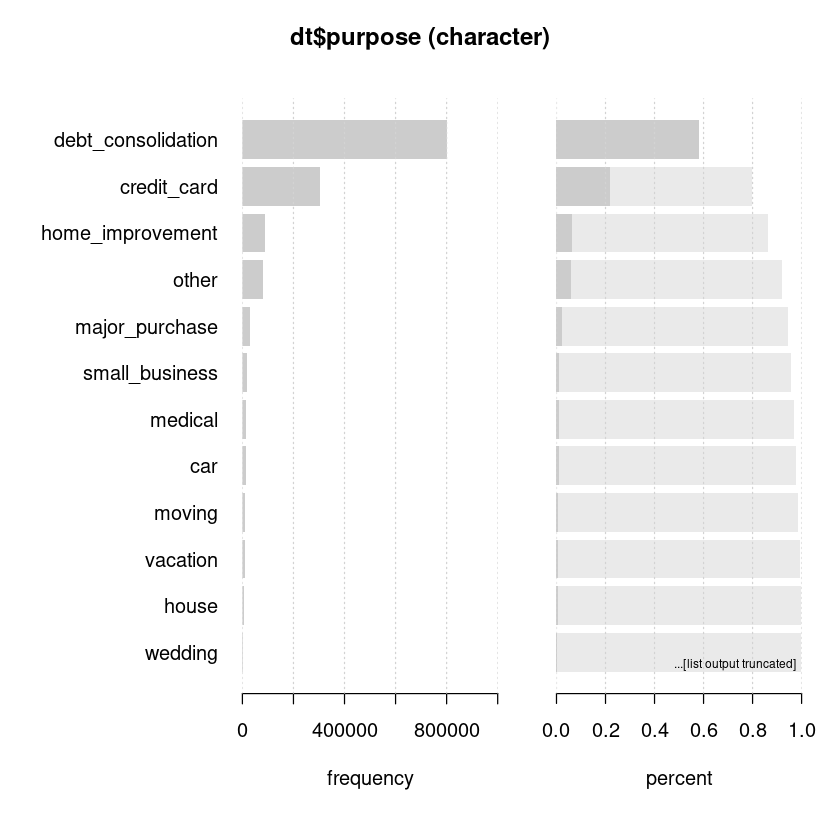

In [39]:
# purpose : A category provided by the borrower for the loan request.
Desc(dt$purpose, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$addr_state (character)

     length         n       NAs    unique    levels     dupes
  1'382'351 1'382'351         0        51        51         y
               100.0%      0.0%                              

    level     freq   perc  cumfreq  cumperc
1      CA  201'525  14.6%  201'525    14.6%
2      NY  113'378   8.2%  314'903    22.8%
3      TX  113'237   8.2%  428'140    31.0%
4      FL   98'634   7.1%  526'774    38.1%
5      IL   53'049   3.8%  579'823    41.9%
6      NJ   49'861   3.6%  629'684    45.6%
7      PA   46'838   3.4%  676'522    48.9%
8      OH   44'870   3.2%  721'392    52.2%
9      GA   44'588   3.2%  765'980    55.4%
10     VA   39'133   2.8%  805'113    58.2%
11     NC   38'793   2.8%  843'906    61.0%
12     MI   36'159   2.6%  880'065    63.7%
... etc.
 [list output truncated]


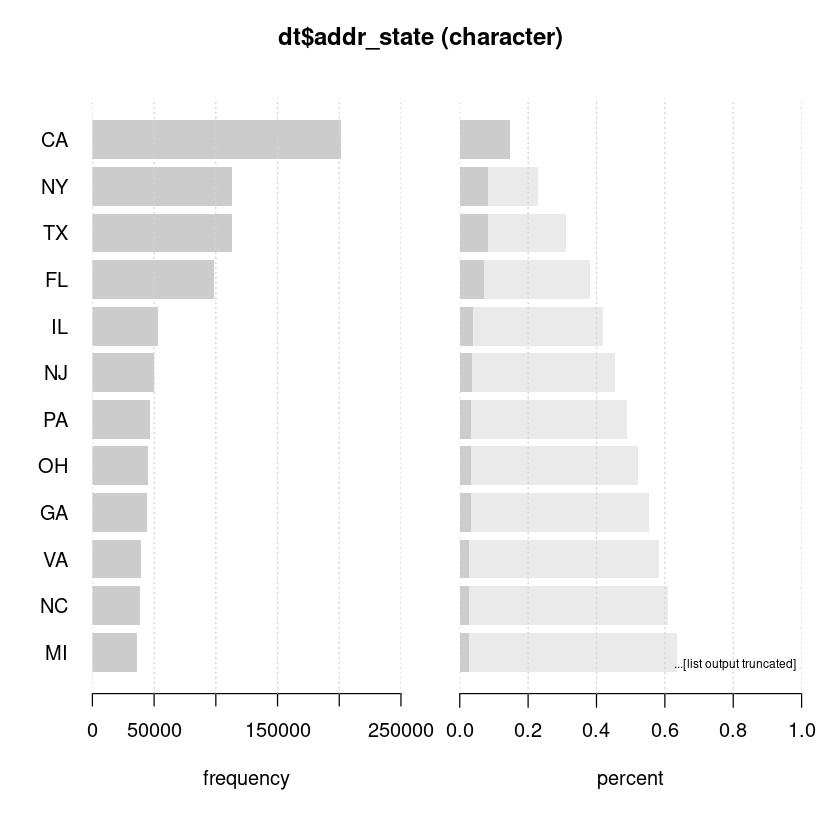

In [40]:
# addr_state : The state provided by the borrower in the loan application
Desc(dt$addr_state, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$dti (numeric)

     length          n    NAs  unique     0s   mean    meanCI'
  1'382'351  1'381'939    412   7'347    925  18.32     18.30
                100.0%   0.0%           0.1%            18.34
                                                             
        .05        .10    .25  median    .75    .90       .95
       4.96       7.26  11.80   17.63  24.09  29.83     33.05
                                                             
      range         sd  vcoef     mad    IQR   skew      kurt
   1'000.00      11.35   0.62    9.07  12.29  27.11  2'063.91
                                                             
lowest : -1.0 (2), 0.0 (925), 0.01 (12), 0.02 (23), 0.03 (10)
highest: 831.97, 879.55, 886.77, 991.57, 999.0 (41)

' 95%-CI (classic)


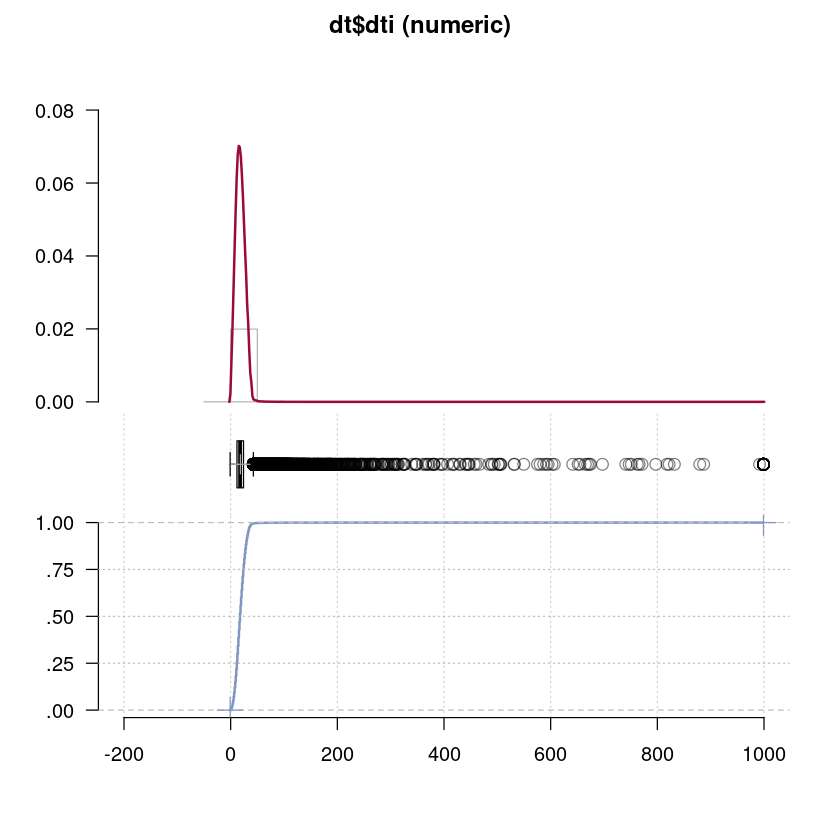

In [41]:
# dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
Desc(dt$dti, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$delinq_2yrs (numeric)

     length          n    NAs  unique         0s  mean  meanCI'
  1'382'351  1'382'322     29      32  1'115'174  0.32    0.32
                100.0%   0.0%              80.7%          0.32
                                                              
        .05        .10    .25  median        .75   .90     .95
       0.00       0.00   0.00    0.00       0.00  1.00    2.00
                                                              
      range         sd  vcoef     mad        IQR  skew    kurt
      39.00       0.88   2.76    0.00       0.00  5.63   59.95
                                                              
lowest : 0.0 (1'115'174), 1.0 (177'418), 2.0 (51'972), 3.0 (18'984), 4.0 (8'379)
highest: 28.0, 29.0 (2), 30.0, 36.0, 39.0

heap(?): remarkable frequency (80.7%) for the mode(s) (= 0)

' 95%-CI (classic)


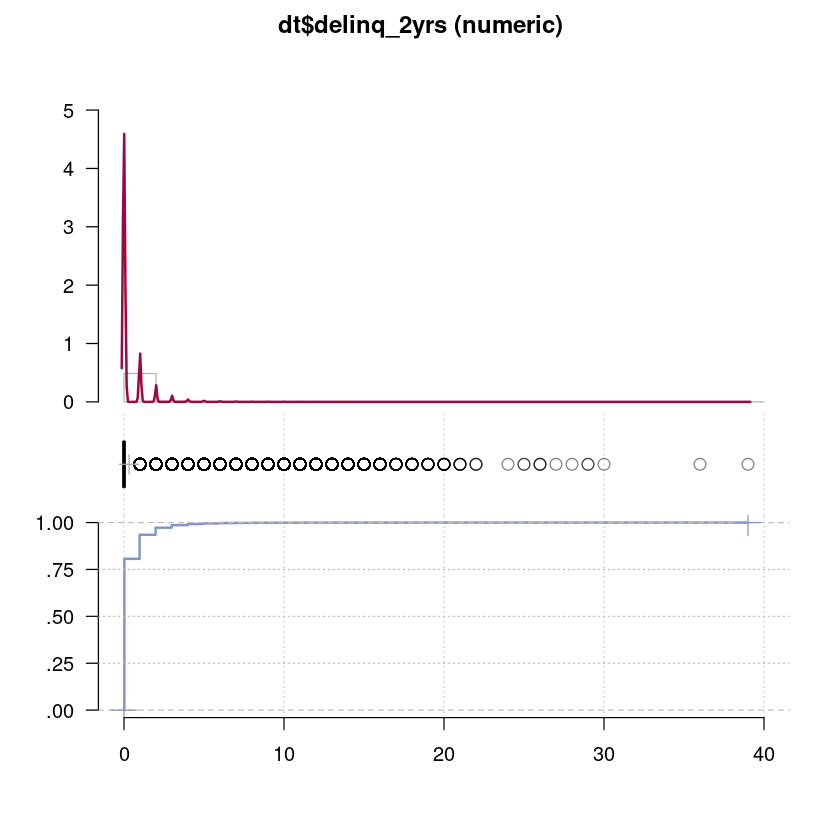

In [42]:
# delinq_2yrs : The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
Desc(dt$delinq_2yrs, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$inq_last_6mths (numeric)

     length          n    NAs  unique       0s  mean  meanCI'
  1'382'351  1'382'321     30      28  790'784  0.66    0.66
                100.0%   0.0%            57.2%          0.66
                                                            
        .05        .10    .25  median      .75   .90     .95
       0.00       0.00   0.00    0.00     1.00  2.00    3.00
                                                            
      range         sd  vcoef     mad      IQR  skew    kurt
      33.00       0.96   1.45    0.00     1.00  2.01    9.96
                                                            
lowest : 0.0 (790'784), 1.0 (376'408), 2.0 (140'290), 3.0 (52'925), 4.0 (14'812)
highest: 27.0, 28.0, 31.0, 32.0, 33.0

heap(?): remarkable frequency (57.2%) for the mode(s) (= 0)

' 95%-CI (classic)


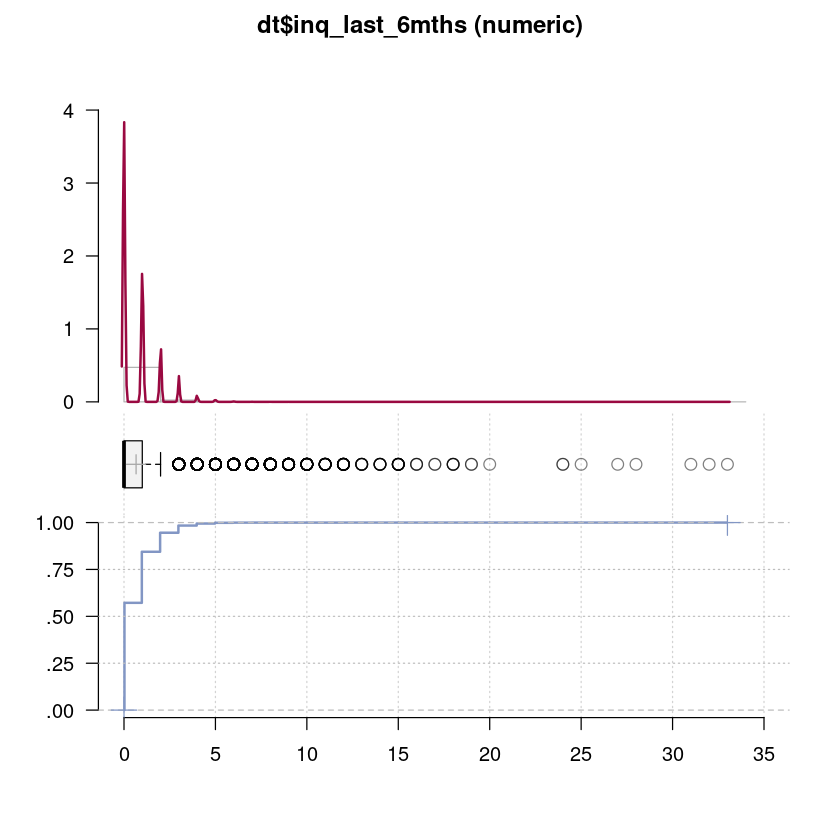

In [43]:
# inq_last_6mths : The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
Desc(dt$inq_last_6mths, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$open_acc (numeric)

     length          n    NAs  unique     0s   mean  meanCI'
  1'382'351  1'382'322     29      84     15  11.59   11.58
                100.0%   0.0%           0.0%          11.60
                                                           
        .05        .10    .25  median    .75    .90     .95
       5.00       6.00   8.00   11.00  14.00  19.00   22.00
                                                           
      range         sd  vcoef     mad    IQR   skew    kurt
      90.00       5.49   0.47    4.45   6.00   1.30    3.34
                                                           
lowest : 0.0 (15), 1.0 (599), 2.0 (5'207), 3.0 (17'094), 4.0 (38'643)
highest: 82.0, 84.0, 86.0, 88.0, 90.0

heap(?): remarkable frequency (8.9%) for the mode(s) (= 9)

' 95%-CI (classic)


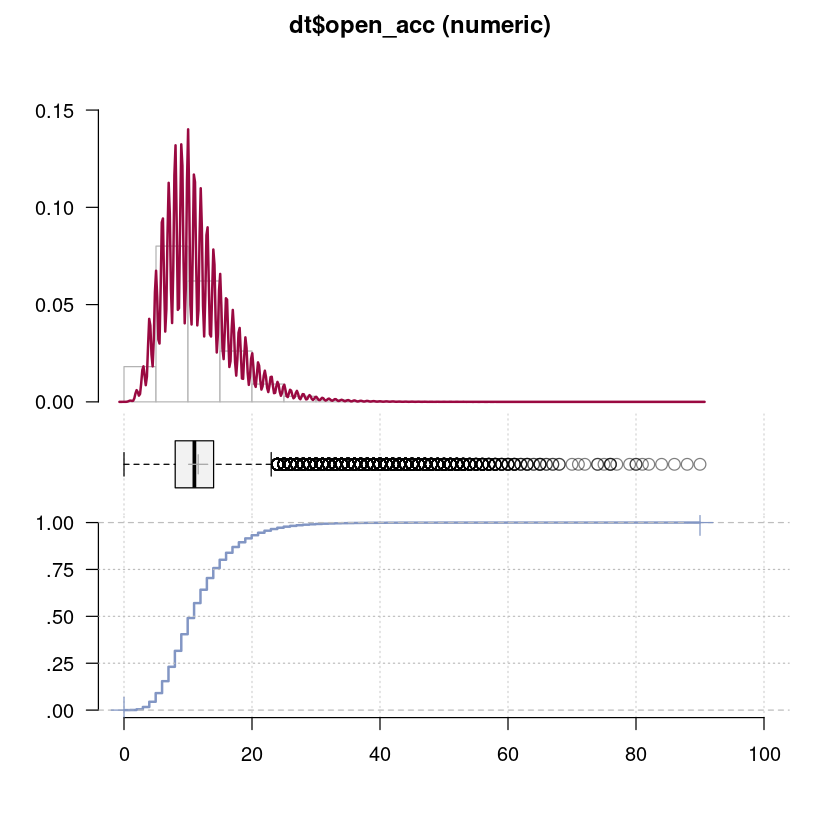

In [44]:
# open_acc : The number of open credit lines in the borrower's credit file.
Desc(dt$open_acc, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$pub_rec (numeric)

     length          n    NAs  unique         0s   mean  meanCI'
  1'382'351  1'382'322     29      39  1'147'978   0.22    0.21
                100.0%   0.0%              83.0%           0.22
                                                               
        .05        .10    .25  median        .75    .90     .95
       0.00       0.00   0.00    0.00       0.00   1.00    1.00
                                                               
      range         sd  vcoef     mad        IQR   skew    kurt
      86.00       0.60   2.80    0.00       0.00  11.85  758.77
                                                               
lowest : 0.0 (1'147'978), 1.0 (196'288), 2.0 (25'050), 3.0 (7'602), 4.0 (2'696)
highest: 49.0 (2), 54.0, 61.0, 63.0, 86.0

heap(?): remarkable frequency (83.0%) for the mode(s) (= 0)

' 95%-CI (classic)


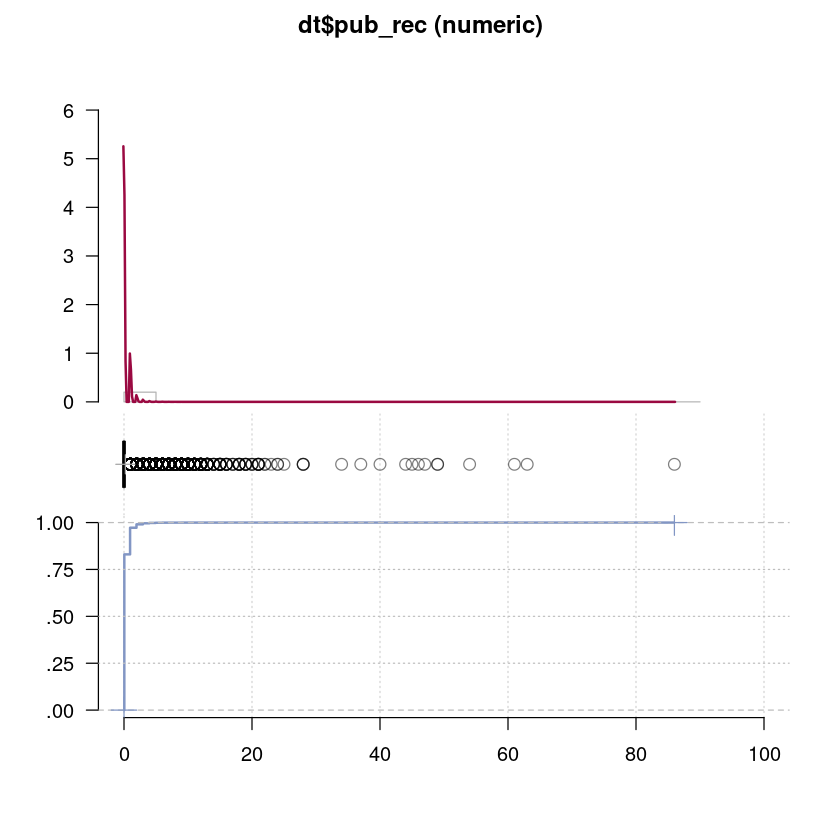

In [45]:
# pub_rec : Number of derogatory public records
Desc(dt$pub_rec, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$revol_bal (numeric)

        length          n       NAs     unique         0s       mean     meanCI'
     1'382'351  1'382'351         0     84'717      6'947  16'251.39  16'213.98
                   100.0%      0.0%                  0.5%             16'288.79
                                                                               
           .05        .10       .25     median        .75        .90        .95
      1'644.00   2'997.00  5'925.00  11'119.00  19'740.00  32'429.00  43'424.00
                                                                               
         range         sd     vcoef        mad        IQR       skew       kurt
  2'904'836.00  22'437.32      1.38   9'141.71  13'815.00      13.66     701.50
                                                                               
lowest : 0.0 (6'947), 1.0 (74), 2.0 (105), 3.0 (95), 4.0 (81)
highest: 1'743'266.0, 1'746'716.0

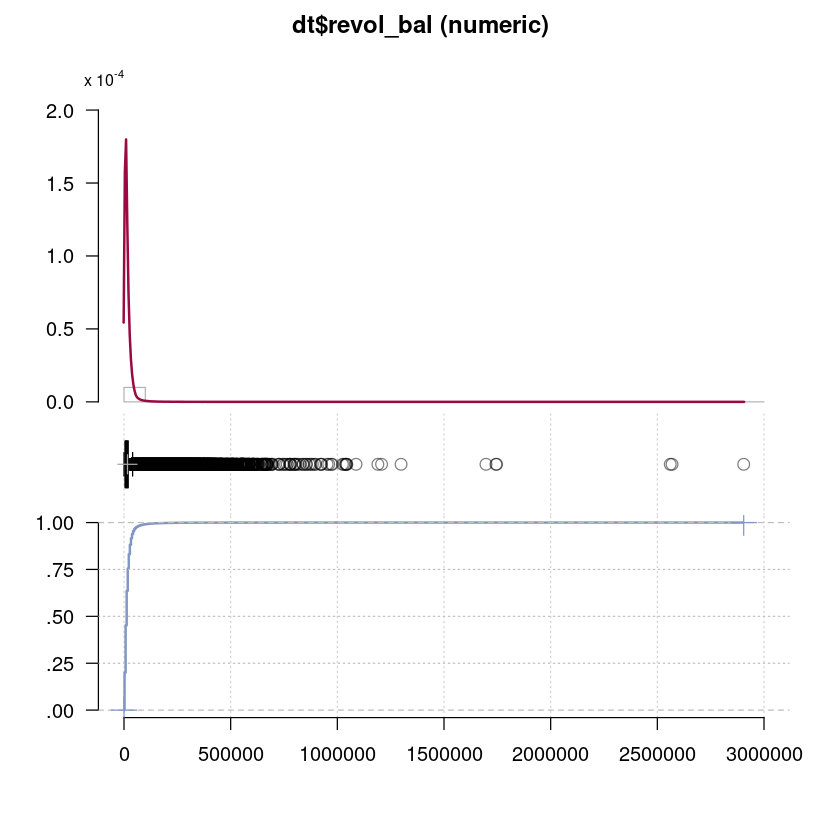

In [46]:
# revol_bal : Total credit revolving balance
Desc(dt$revol_bal, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$revol_util (numeric)

     length          n    NAs  unique     0s   mean  meanCI'
  1'382'351  1'381'416    935   1'382  7'325  51.78   51.74
                 99.9%   0.1%           0.5%          51.82
                                                           
        .05        .10    .25  median    .75    .90     .95
      10.30      18.10  33.40   52.10  70.70  85.00   91.50
                                                           
      range         sd  vcoef     mad    IQR   skew    kurt
     892.30      24.54   0.47   27.72  37.30  -0.04    0.21
                                                           
lowest : 0.0 (7'325), 0.01, 0.03, 0.04, 0.05
highest: 182.8, 184.6, 193.0, 366.6, 892.3

' 95%-CI (classic)


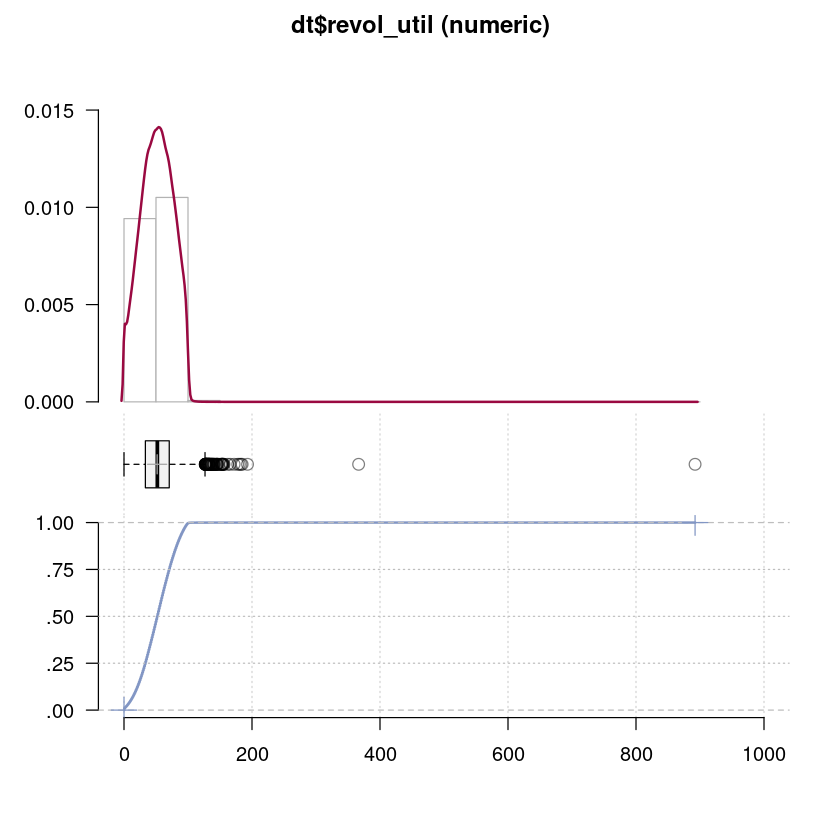

In [47]:
# revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
Desc(dt$revol_util, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$total_acc (numeric)

     length          n    NAs  unique     0s   mean  meanCI'
  1'382'351  1'382'322     29     144      0  24.93   24.91
                100.0%   0.0%           0.0%          24.95
                                                           
        .05        .10    .25  median    .75    .90     .95
       9.00      11.00  16.00   23.00  32.00  41.00   47.00
                                                           
      range         sd  vcoef     mad    IQR   skew    kurt
     175.00      12.01   0.48   11.86  16.00   0.96    1.68
                                                           
lowest : 1.0 (21), 2.0 (398), 3.0 (1'484), 4.0 (5'103), 5.0 (8'276)
highest: 156.0, 162.0, 169.0, 173.0, 176.0

' 95%-CI (classic)


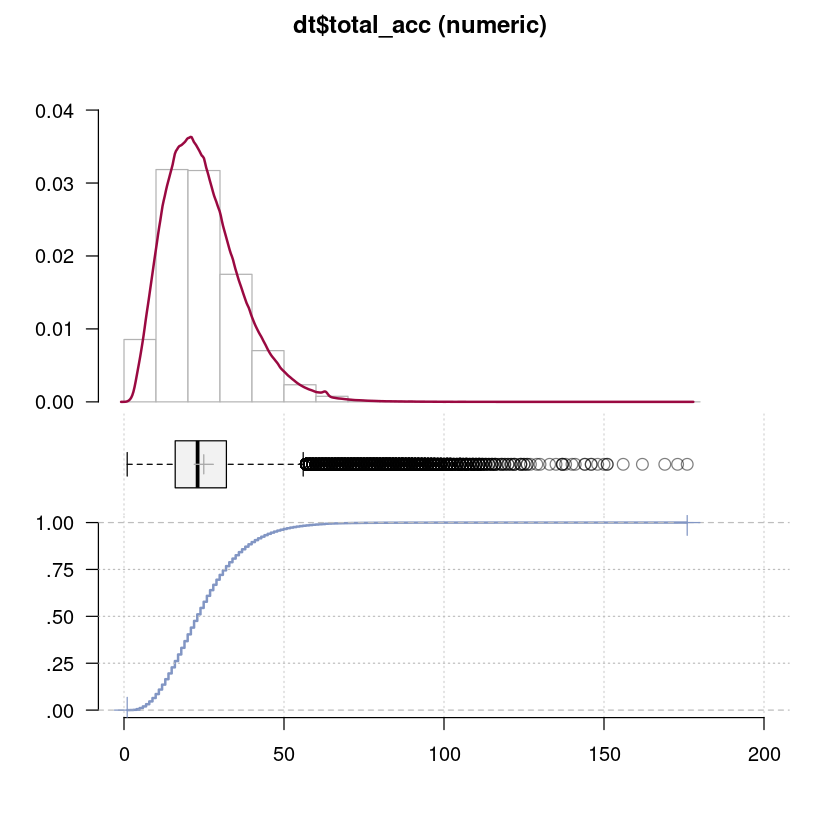

In [48]:
# total_acc : The total number of credit lines currently in the borrower's credit file
Desc(dt$total_acc, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$initial_list_status (character - dichotomous)

     length         n       NAs    unique
  1'382'351 1'382'351         0         2
               100.0%      0.0%          

      freq   perc  lci.95  uci.95'
w  810'885  58.7%   58.6%   58.7%
f  571'466  41.3%   41.3%   41.4%

' 95%-CI (Wilson)


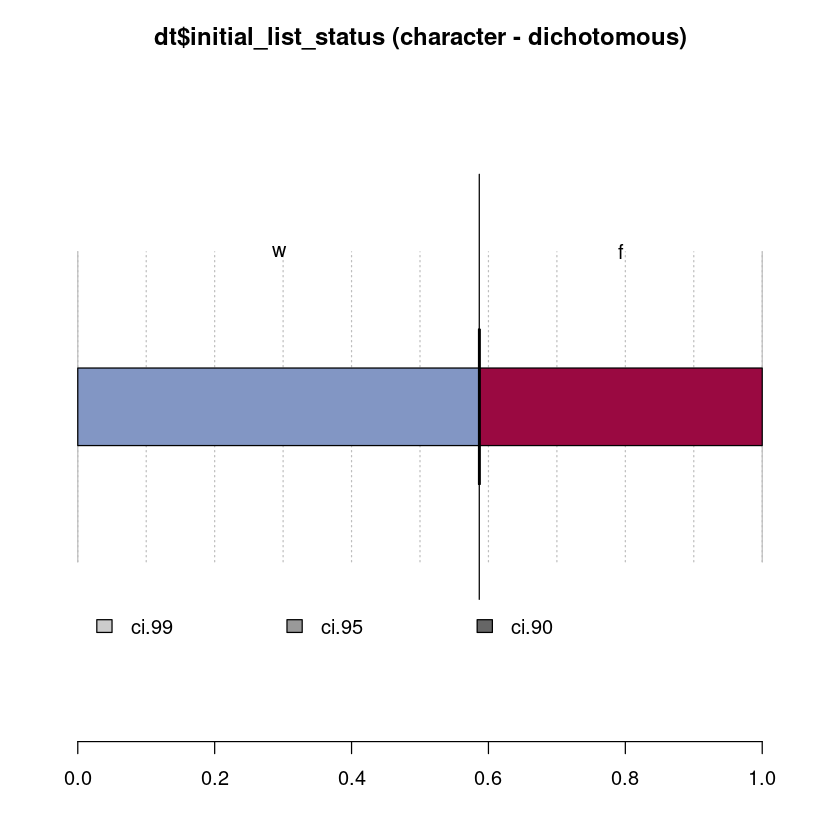

In [49]:
# initial_list_status : The initial listing status of the loan. Possible values are – W, F
Desc(dt$initial_list_status, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$last_pymnt_amnt (numeric)

     length          n     NAs    unique        0s       mean     meanCI'
  1'382'351  1'382'351       0   694'999     2'893   5'295.30   5'283.52
                100.0%    0.0%                0.2%              5'307.09
                                                                        
        .05        .10     .25    median       .75        .90        .95
      86.65     180.64  389.44  1'805.59  8'029.94  15'306.66  20'440.30
                                                                        
      range         sd   vcoef       mad       IQR       skew       kurt
  42'192.05   7'067.37    1.33  2'449.89  7'640.50       1.82       3.27
                                                                        
lowest : 0.0 (2'893), 0.01 (289), 0.02 (96), 0.03 (83), 0.04 (79)
highest: 41'434.0, 41'453.07, 42'005.20, 42'148.53, 42'192.05

' 95%-CI (classic)


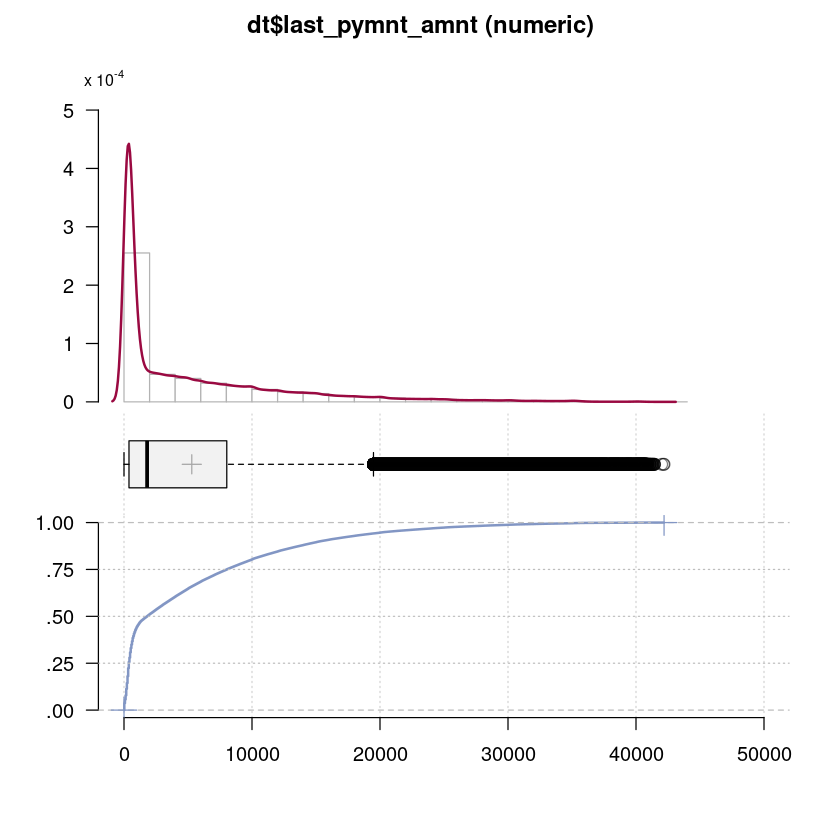

In [59]:
# last_pymnt_amnt : Last total payment amount received
Desc(dt$last_pymnt_amnt, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$application_type (character - dichotomous)

     length         n       NAs    unique
  1'382'351 1'382'351         0         2
               100.0%      0.0%          

                 freq   perc  lci.95  uci.95'
Individual  1'352'767  97.9%   97.8%   97.9%
Joint App      29'584   2.1%    2.1%    2.2%

' 95%-CI (Wilson)


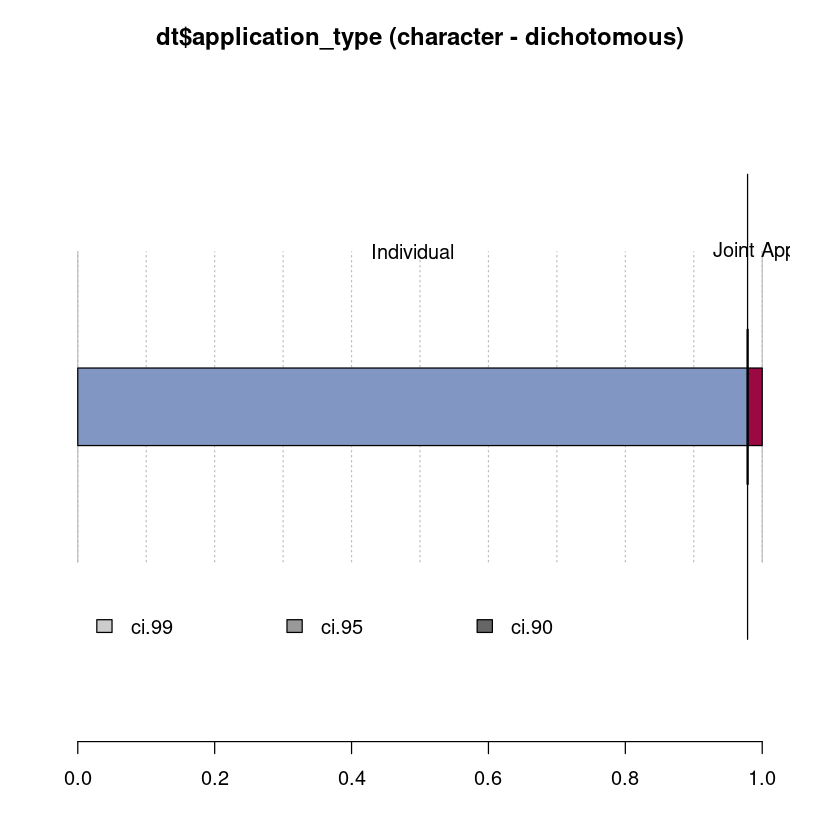

In [61]:
# application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
Desc(dt$application_type, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$tot_coll_amt (numeric)

        length          n     NAs  unique         0s    mean      meanCI'
     1'382'351  1'312'075  70'276  13'005  1'110'400  248.93      230.24
                    94.9%    5.1%              80.3%              267.62
                                                                        
           .05        .10     .25  median        .75     .90         .95
          0.00       0.00    0.00    0.00       0.00  214.00      781.00
                                                                        
         range         sd   vcoef     mad        IQR    skew        kurt
  9'152'545.00  10'923.07   43.88    0.00       0.00  674.52  496'308.41
                                                                        
lowest : 0.0 (1'110'400), 2.0 (4), 3.0 (2), 4.0, 5.0
highest: 848'438.0, 932'461.0, 5'252'395.0, 6'214'661.0, 9'152'545.0

heap(?): remarkable frequency (84.6%) f

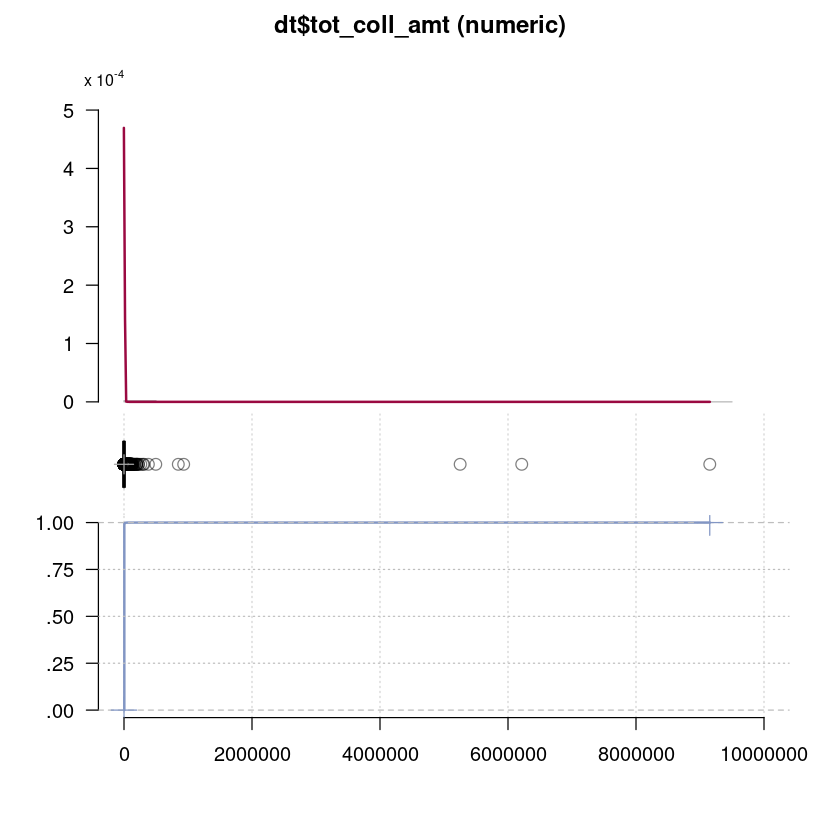

In [64]:
# tot_coll_amt : Total collection amounts ever owed
Desc(dt$tot_coll_amt, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$tot_cur_bal (numeric)

        length           n        NAs     unique          0s        mean'
     1'382'351   1'312'075     70'276    404'473         409  140'965.28
                     94.9%       5.1%                   0.0%            
                                                                        
           .05         .10        .25     median         .75         .90
      8'587.00   14'030.00  29'362.00  79'769.00  210'500.00  340'454.00
                                                                        
         range          sd      vcoef        mad         IQR        skew
  8'000'078.00  157'496.23       1.12  93'532.79  181'138.00        2.88
                                                                        
      meanCI
  140'695.79
  141'234.77
            
         .95
  433'581.20
            
        kurt
       26.29
            
lowest : 0.0 (409), 1.0 (8), 2.0 

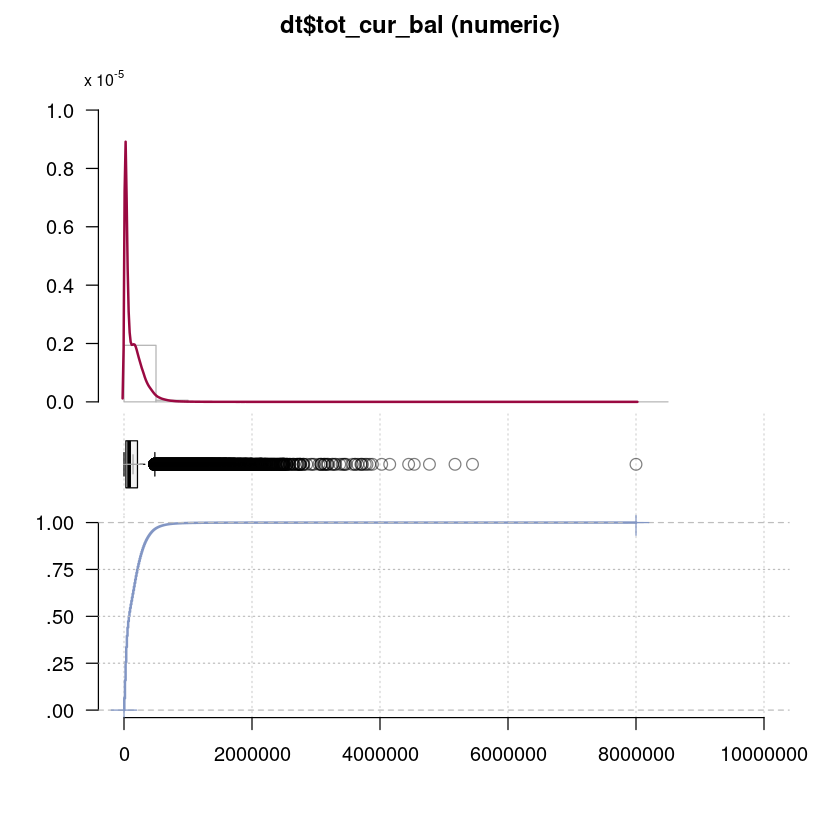

In [65]:
# tot_cur_bal : Total current balance of all accounts
Desc(dt$tot_cur_bal, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$total_rev_hi_lim (numeric)

        length          n        NAs     unique         0s       mean'
     1'382'351  1'312'075     70'276     27'203        648  32'751.34
                    94.9%       5.1%                  0.0%           
                                                                     
           .05        .10        .25     median        .75        .90
      5'900.00   8'300.00  14'000.00  24'100.00  40'600.00  64'300.00
                                                                     
         range         sd      vcoef        mad        IQR       skew
  9'999'999.00  36'509.18       1.11  17'642.94  26'600.00      51.06
                                                                     
     meanCI
  32'688.87
  32'813.81
           
        .95
  85'786.70
           
       kurt
  12'772.69
           
lowest : 0.0 (648), 100.0 (16), 200.0 (30), 300.0 (162), 400.0 (61)


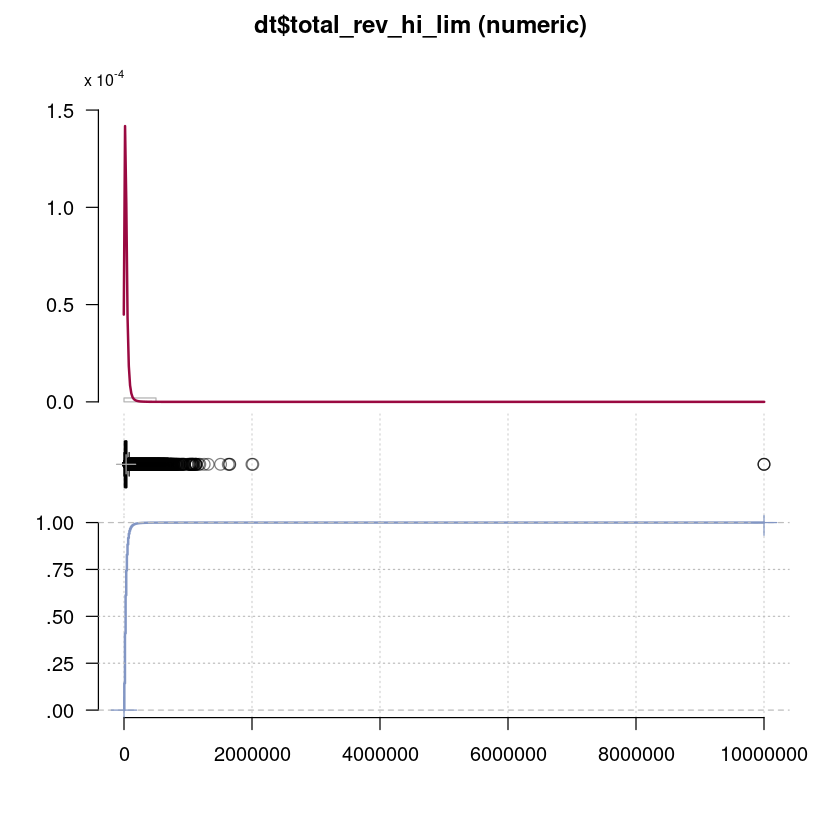

In [66]:
# total_rev_hi_lim : NA
Desc(dt$total_rev_hi_lim, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$issue_month (character)

     length         n       NAs    unique    levels     dupes
  1'382'351 1'382'351         0        12        12         y
               100.0%      0.0%                              

    level     freq   perc    cumfreq  cumperc
1     Oct  139'715  10.1%    139'715    10.1%
2     Jul  132'994   9.6%    272'709    19.7%
3     Mar  129'505   9.4%    402'214    29.1%
4     Nov  117'017   8.5%    519'231    37.6%
5     Aug  115'801   8.4%    635'032    45.9%
6     Jan  115'538   8.4%    750'570    54.3%
7     Apr  112'703   8.2%    863'273    62.4%
8     May  107'647   7.8%    970'920    70.2%
9     Dec  107'595   7.8%  1'078'515    78.0%
10    Feb  106'643   7.7%  1'185'158    85.7%
11    Jun  103'598   7.5%  1'288'756    93.2%
12    Sep   93'595   6.8%  1'382'351   100.0%


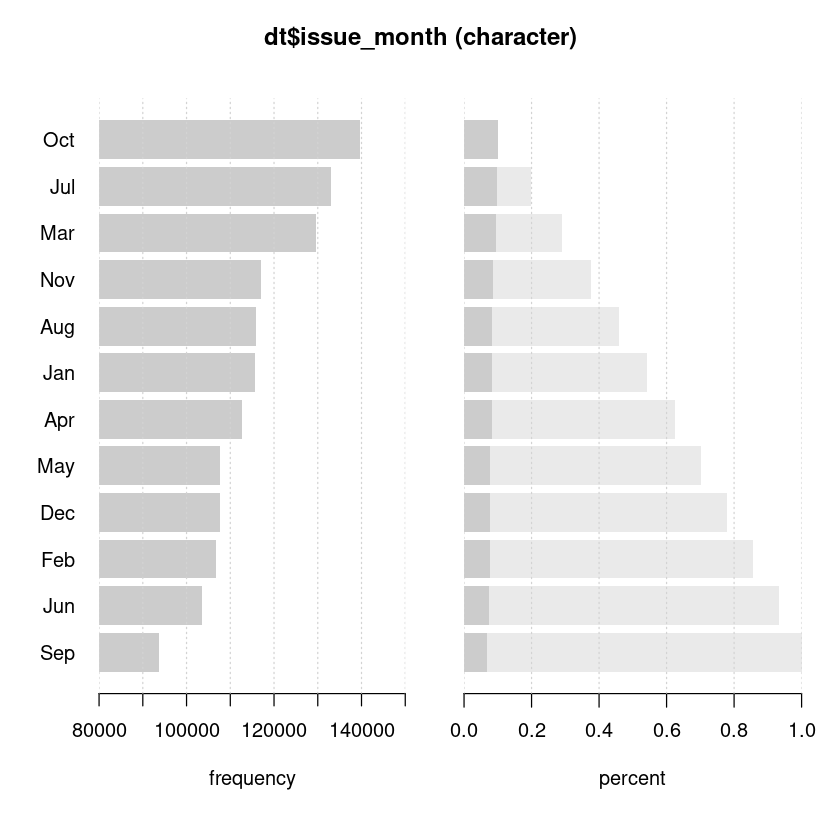

In [67]:
# issue_month : NA
Desc(dt$issue_month, plotit = TRUE)

------------------------------------------------------------------------------ 
dt$loan_outcome (factor - dichotomous)

     length         n       NAs    unique
  1'382'351 1'382'351         0         2
               100.0%      0.0%          

        freq   perc  lci.95  uci.95'
0  1'078'739  78.0%   78.0%   78.1%
1    303'612  22.0%   21.9%   22.0%

' 95%-CI (Wilson)


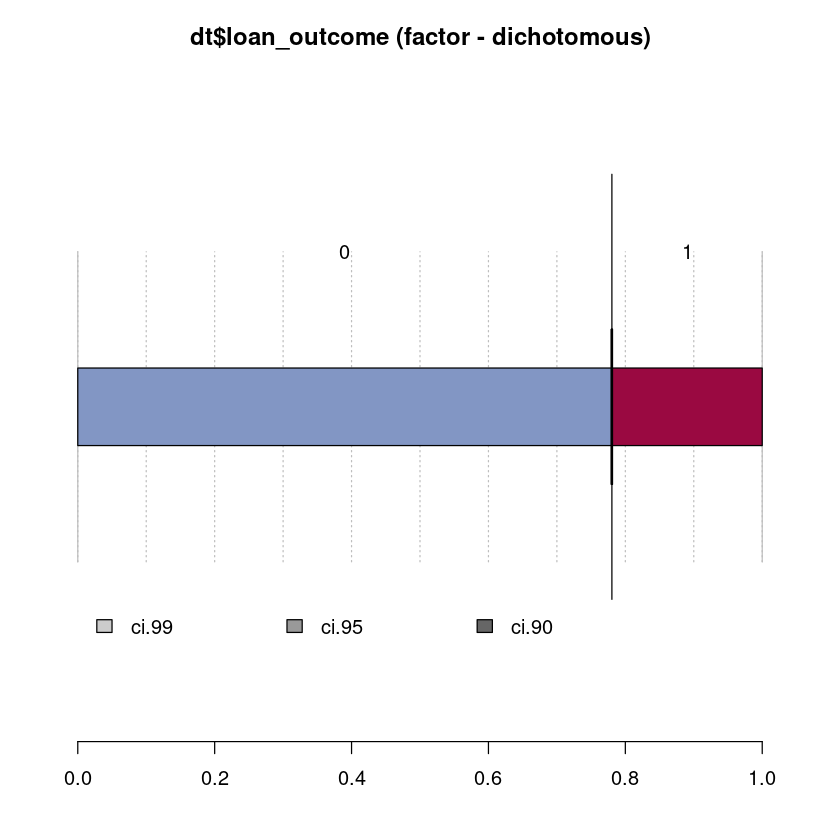

In [68]:
# loan_outcome : NA
Desc(dt$loan_outcome, plotit = TRUE)

## Bivariate Analysis

Target (loan_outcome) profiling: The following charts tries to show if a variable is important or not, with respect to the target variable (loan_outcome) by making a visual summary of it.

Plotting transformed variable 'loan_amnt' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



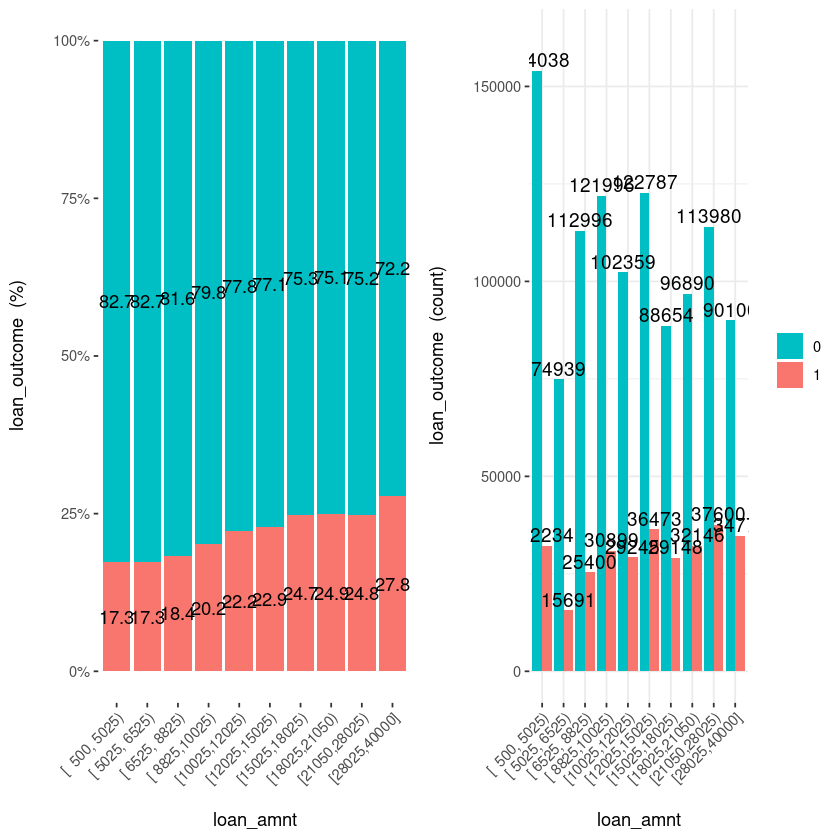

In [70]:
# Cross Plot 'loan_amnt' vs 'loan_outcome'
cross_plot(dt, input='loan_amnt', target='loan_outcome')

Plotting transformed variable 'funded_amnt' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



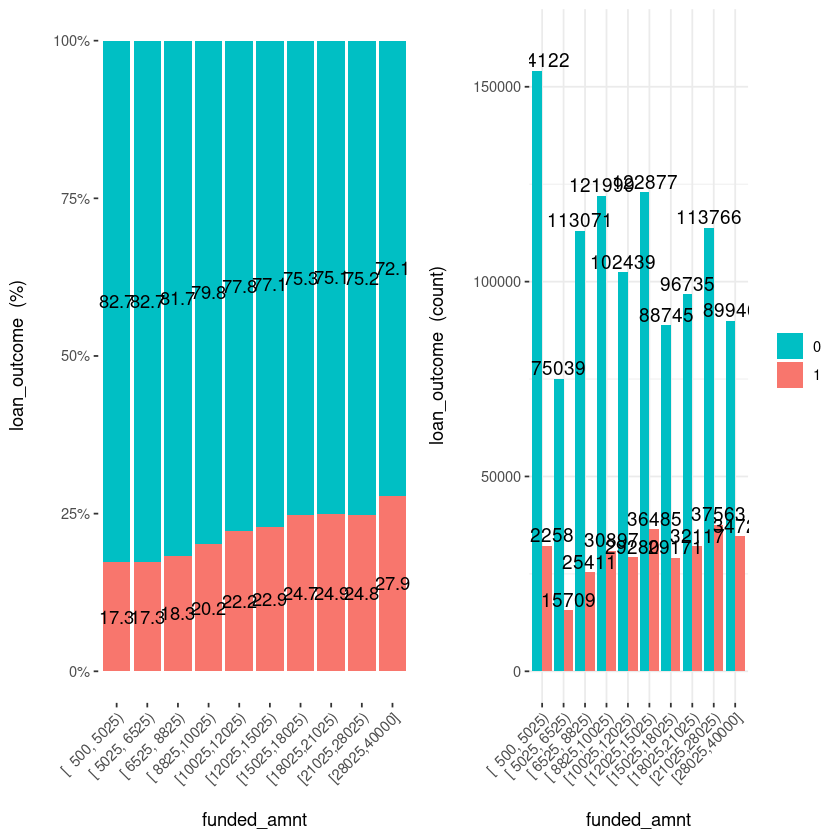

In [71]:
# Cross Plot 'funded_amnt' vs 'loan_outcome'
cross_plot(dt, input='funded_amnt', target='loan_outcome'
           #
           )

Plotting transformed variable 'funded_amnt_inv' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



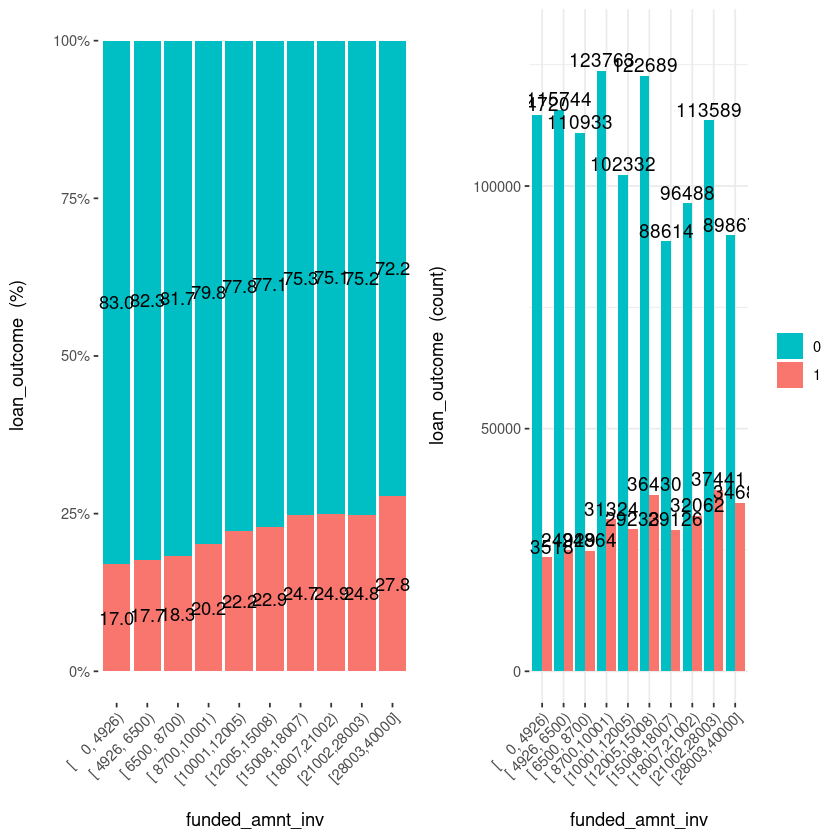

In [72]:
# Cross Plot 'funded_amnt_inv' vs 'loan_outcome'
cross_plot(dt, input='funded_amnt_inv', target='loan_outcome'
           #
           )

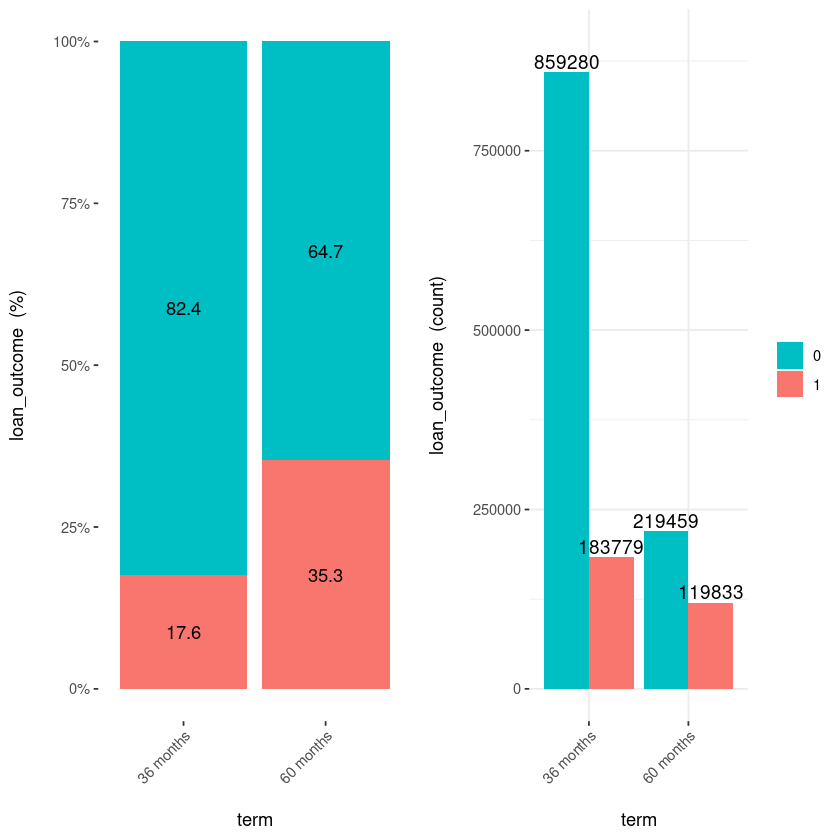

In [73]:
# Cross Plot 'term' vs 'loan_outcome'
cross_plot(dt, input='term', target='loan_outcome'
           #
           )

Plotting transformed variable 'int_rate' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



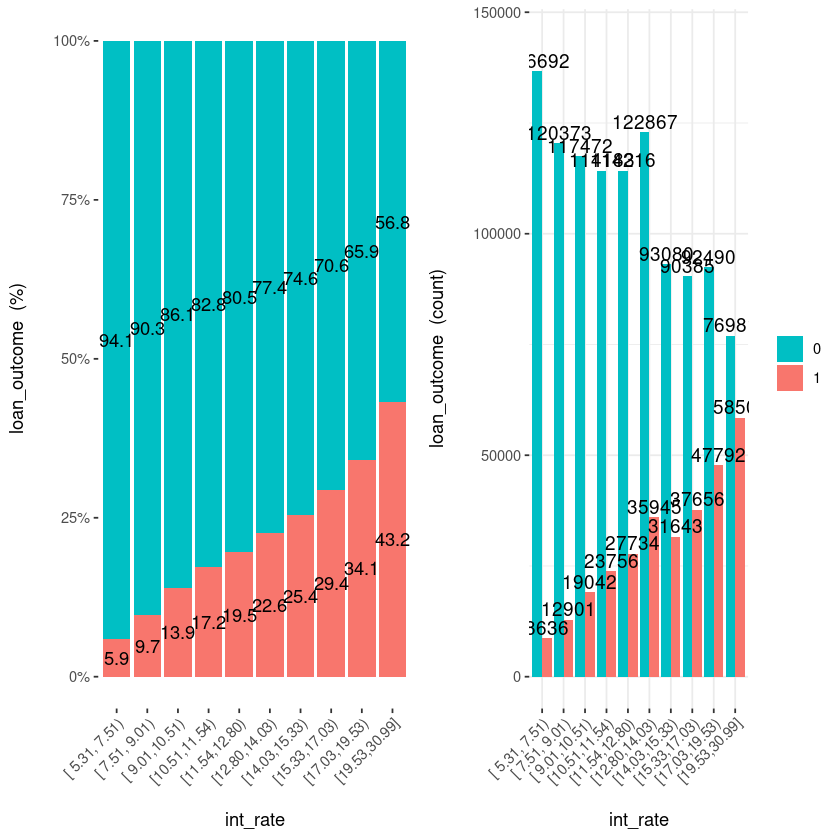

In [74]:
# Cross Plot 'int_rate' vs 'loan_outcome'
cross_plot(dt, input='int_rate', target='loan_outcome')

Plotting transformed variable 'installment' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



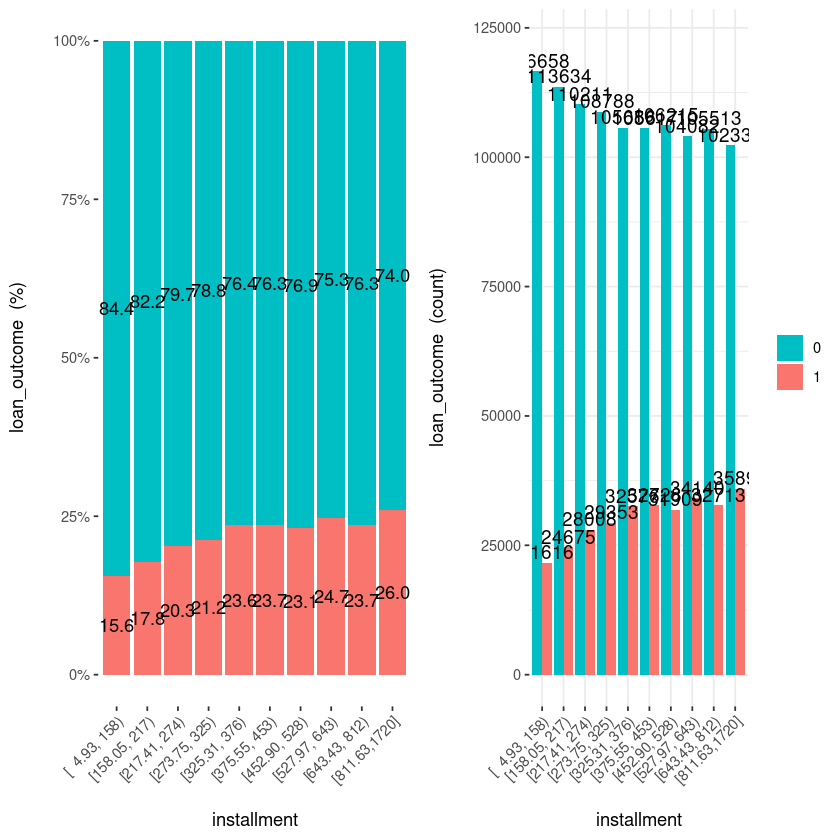

In [75]:
# Cross Plot 'installment' vs 'loan_outcome'
cross_plot(dt, input='installment', target='loan_outcome')

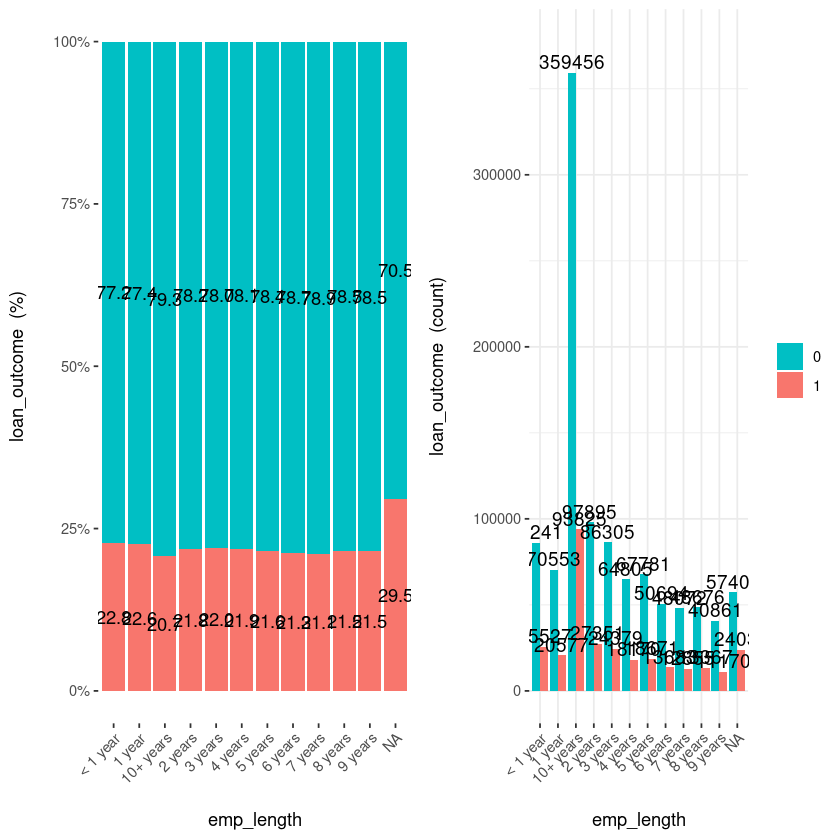

In [78]:
# Cross Plot 'emp_length' vs 'loan_outcome'
cross_plot(dt, input='emp_length', target='loan_outcome')

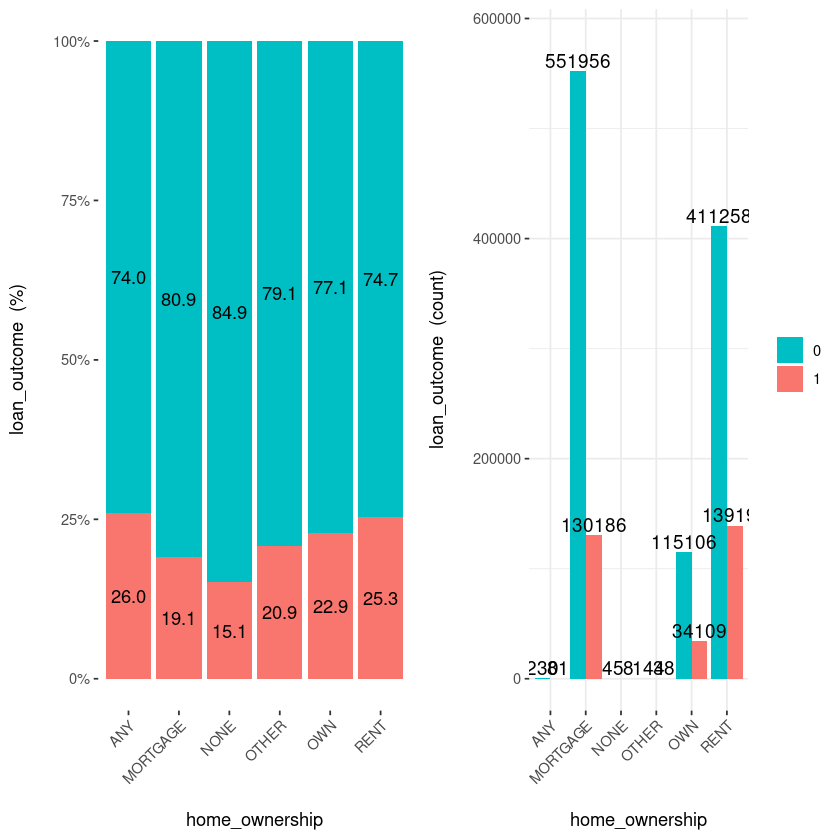

In [79]:
# Cross Plot 'home_ownership' vs 'loan_outcome'
cross_plot(dt, input='home_ownership', target='loan_outcome')

Plotting transformed variable 'annual_inc' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



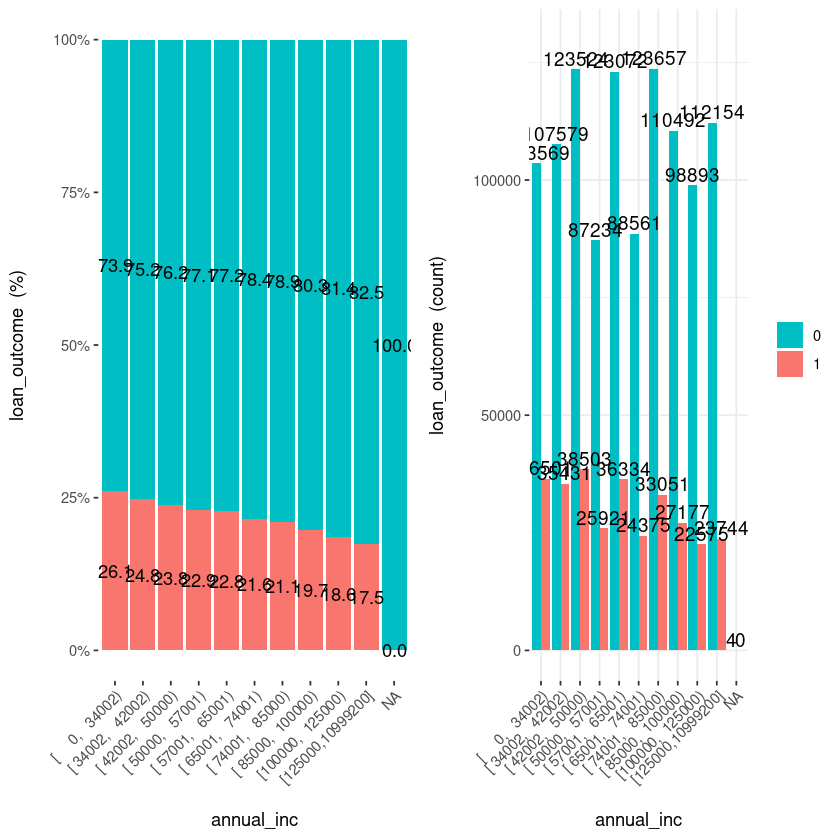

In [80]:
# Cross Plot 'annual_inc' vs 'loan_outcome'
cross_plot(dt, input='annual_inc', target='loan_outcome')

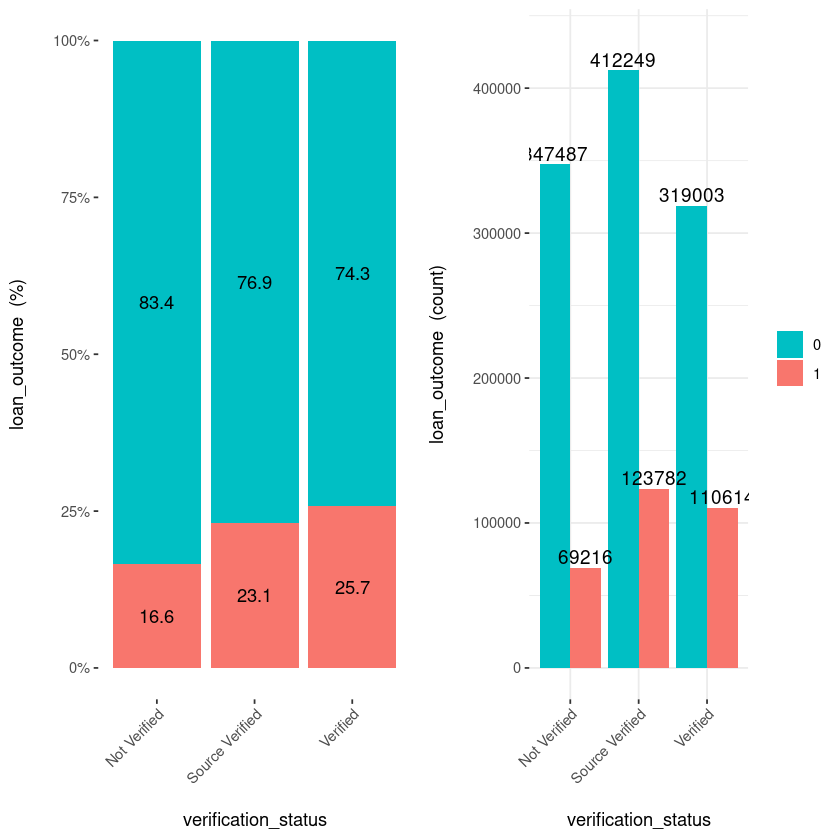

In [81]:
# Cross Plot 'verification_status' vs 'loan_outcome'
cross_plot(dt, input='verification_status', target='loan_outcome')

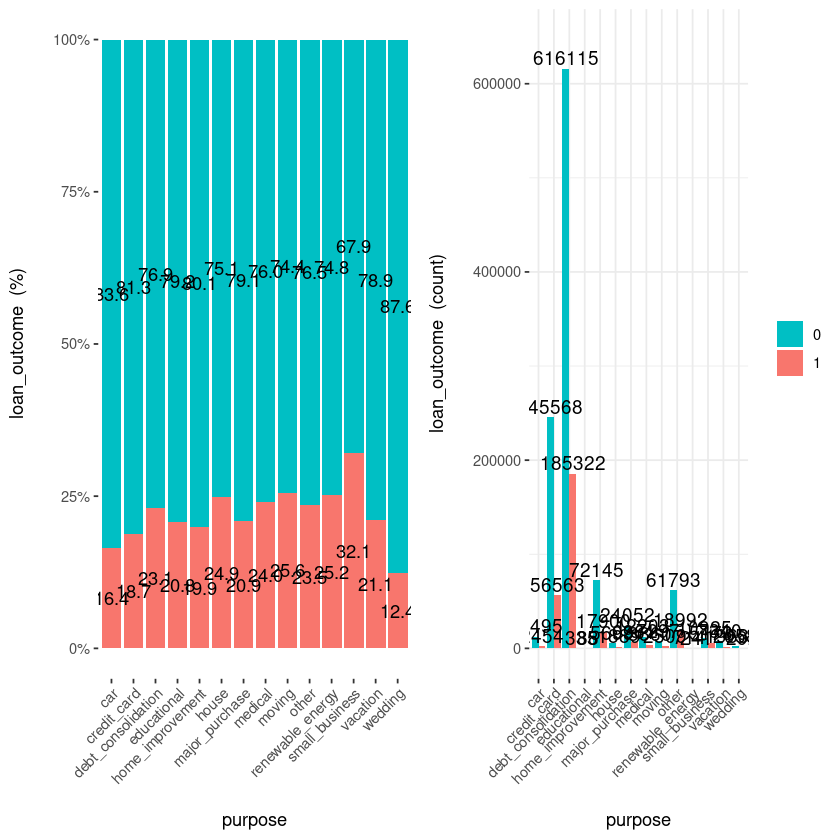

In [83]:
# Cross Plot 'purpose' vs 'loan_outcome'
cross_plot(dt, input='purpose', target='loan_outcome')

Plotting transformed variable 'dti' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



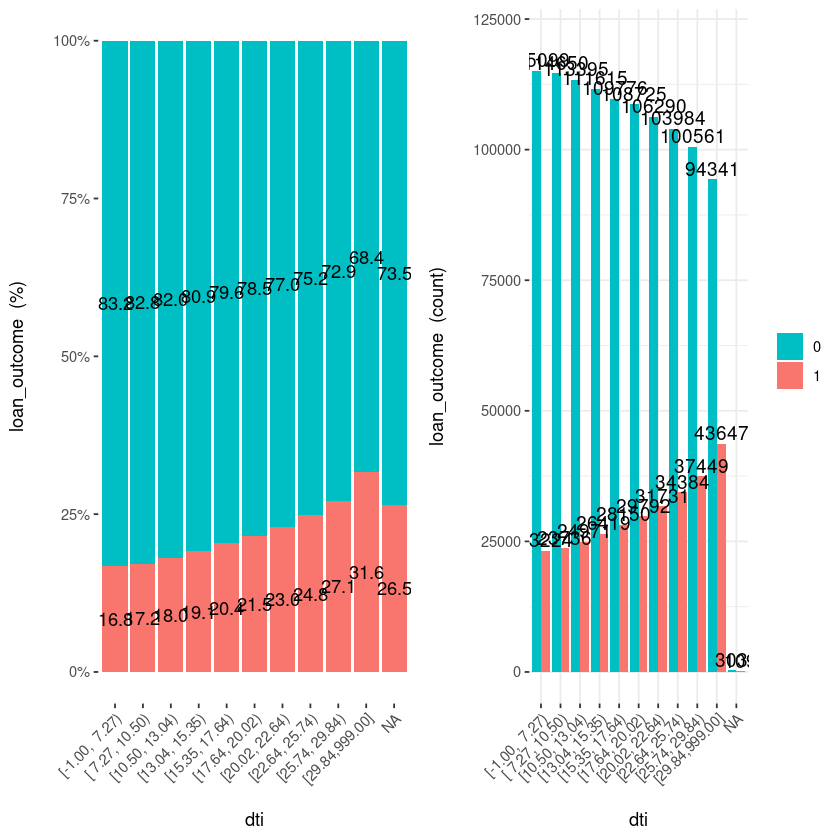

In [84]:
# Cross Plot 'dti' vs 'loan_outcome'
cross_plot(dt, input='dti', target='loan_outcome')

Plotting transformed variable 'delinq_2yrs' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



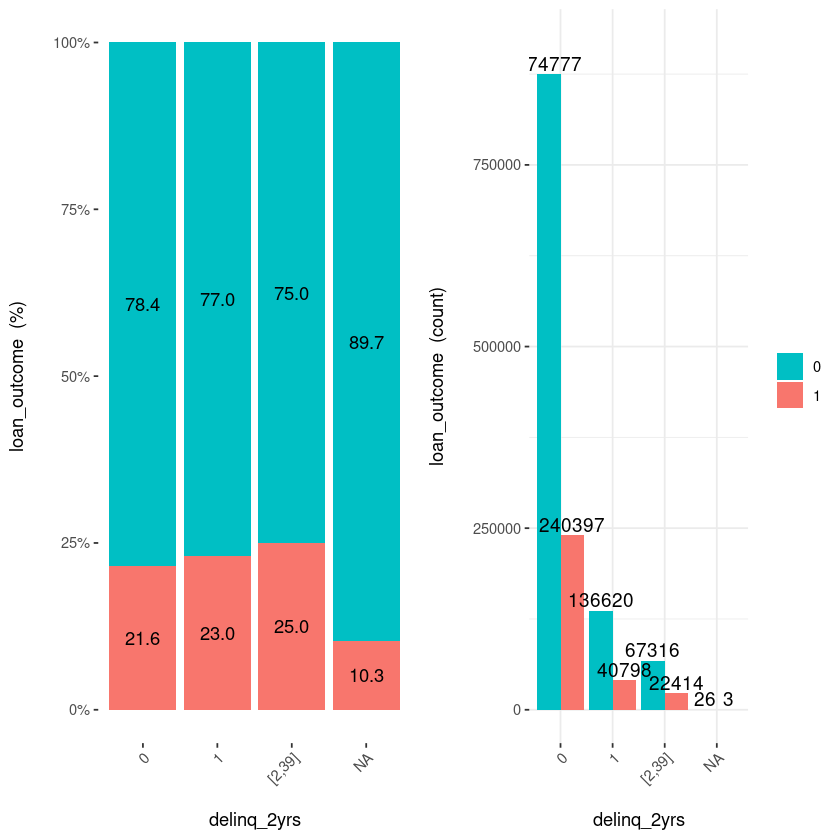

In [85]:
# Cross Plot 'delinq_2yrs' vs 'loan_outcome'
cross_plot(dt, input='delinq_2yrs', target='loan_outcome')

Plotting transformed variable 'inq_last_6mths' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



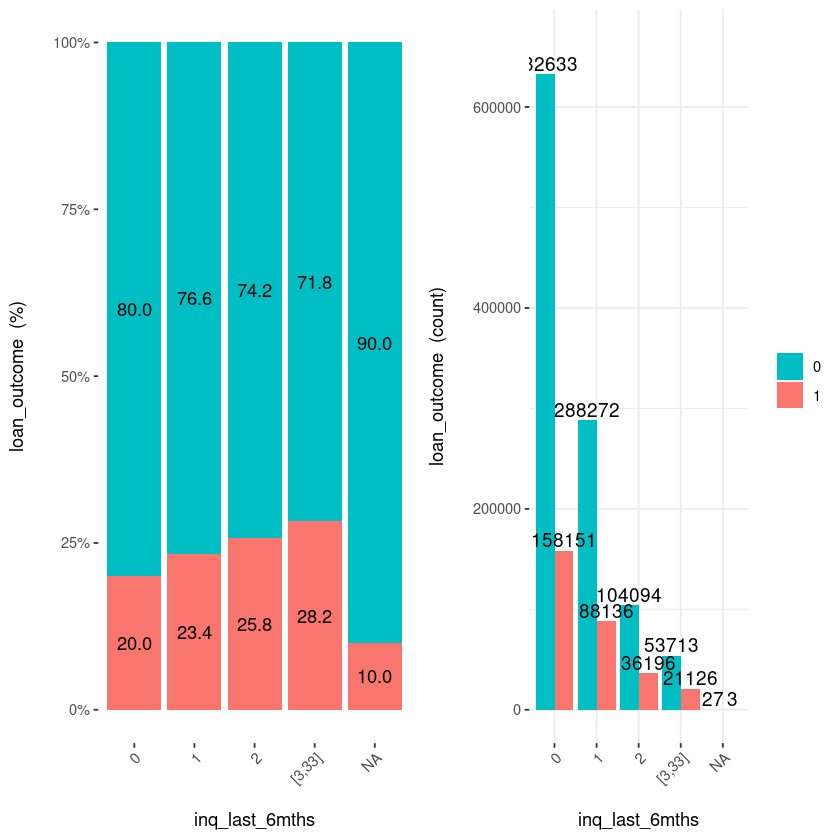

In [86]:
# Cross Plot 'inq_last_6mths' vs 'loan_outcome'
cross_plot(dt, input='inq_last_6mths', target='loan_outcome')

Plotting transformed variable 'open_acc' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



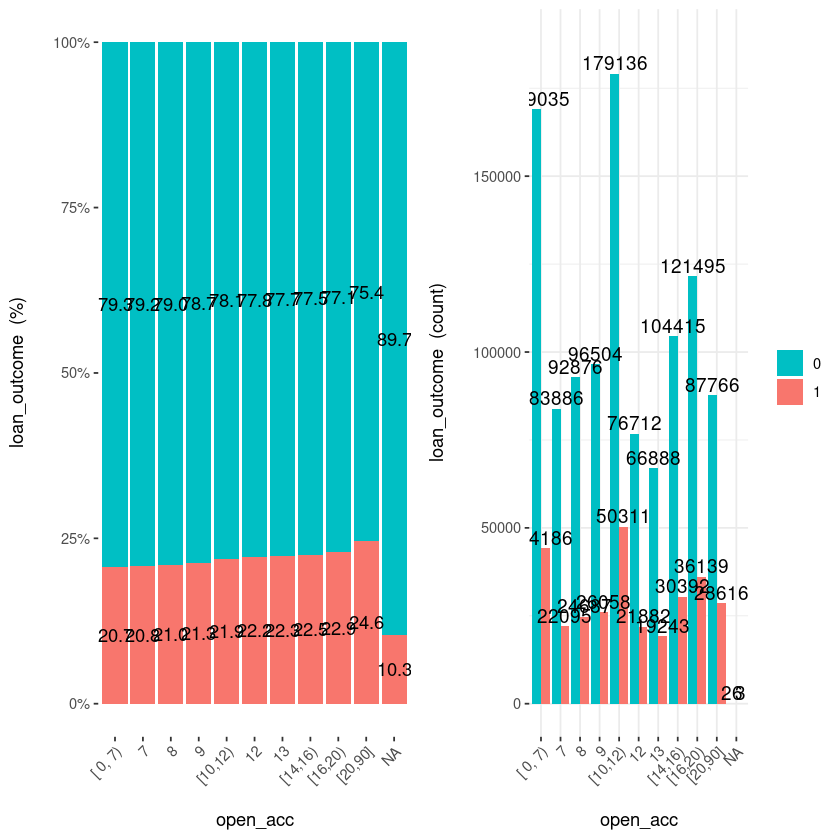

In [87]:
# Cross Plot 'open_acc' vs 'loan_outcome'
cross_plot(dt, input='open_acc', target='loan_outcome')

Plotting transformed variable 'pub_rec' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



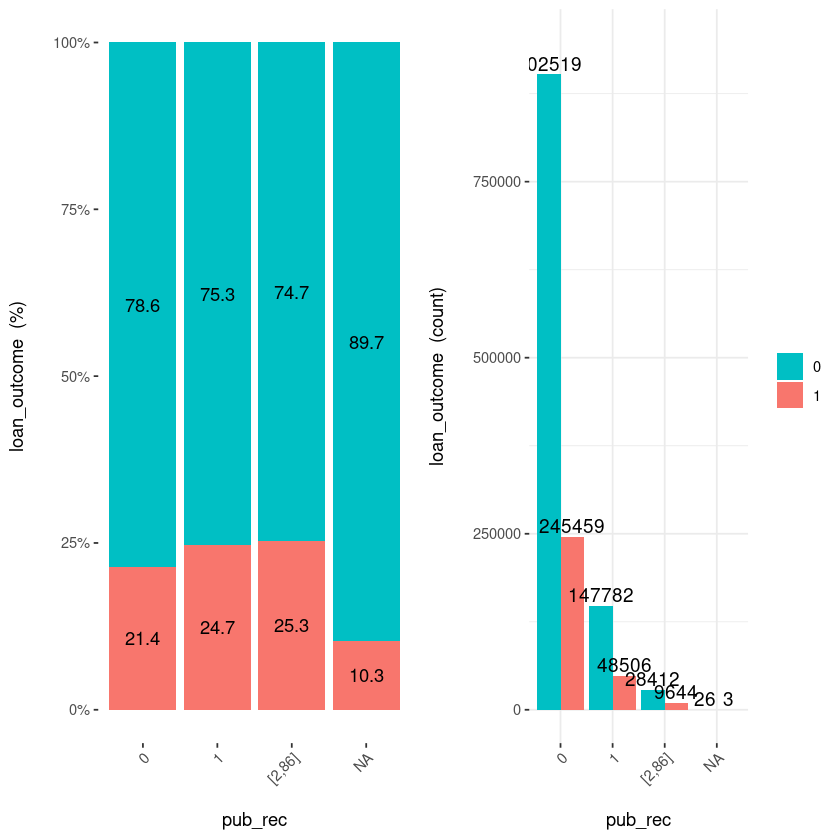

In [88]:
# Cross Plot 'pub_rec' vs 'loan_outcome'
cross_plot(dt, input='pub_rec', target='loan_outcome')

Plotting transformed variable 'revol_bal' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



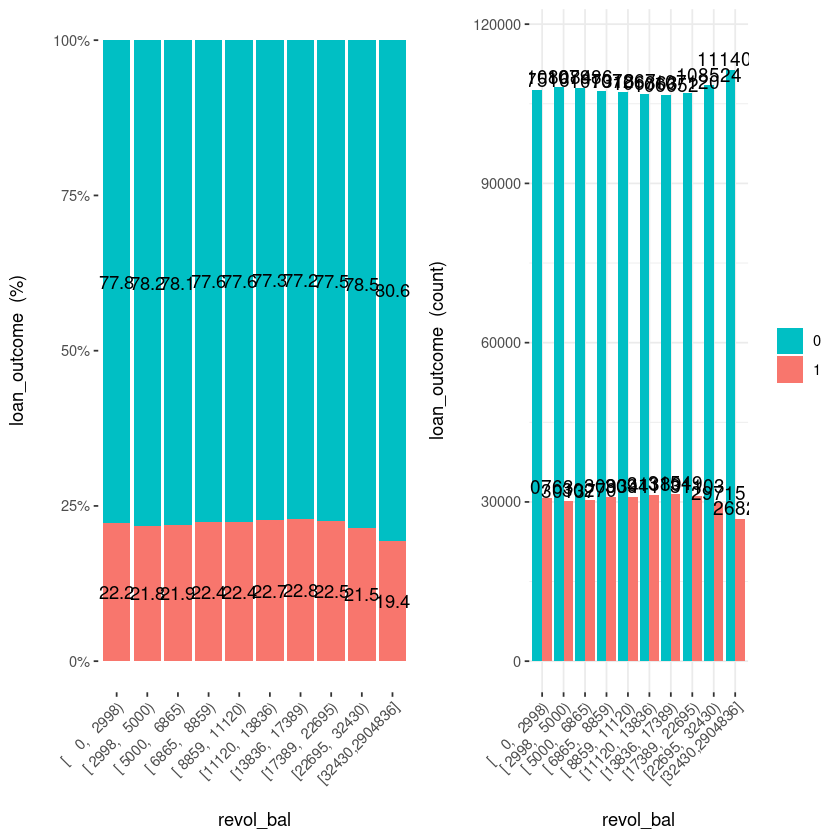

In [89]:
# Cross Plot 'revol_bal' vs 'loan_outcome'
cross_plot(dt, input='revol_bal', target='loan_outcome')

Plotting transformed variable 'revol_util' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



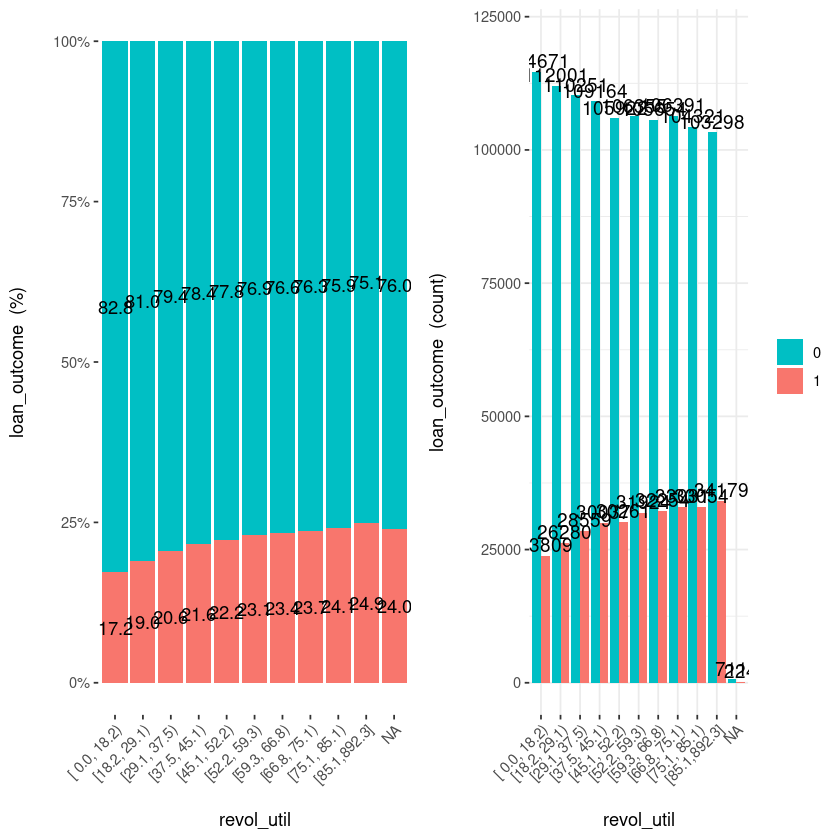

In [90]:
# Cross Plot 'revol_util' vs 'loan_outcome'
cross_plot(dt, input='revol_util', target='loan_outcome')

Plotting transformed variable 'total_acc' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



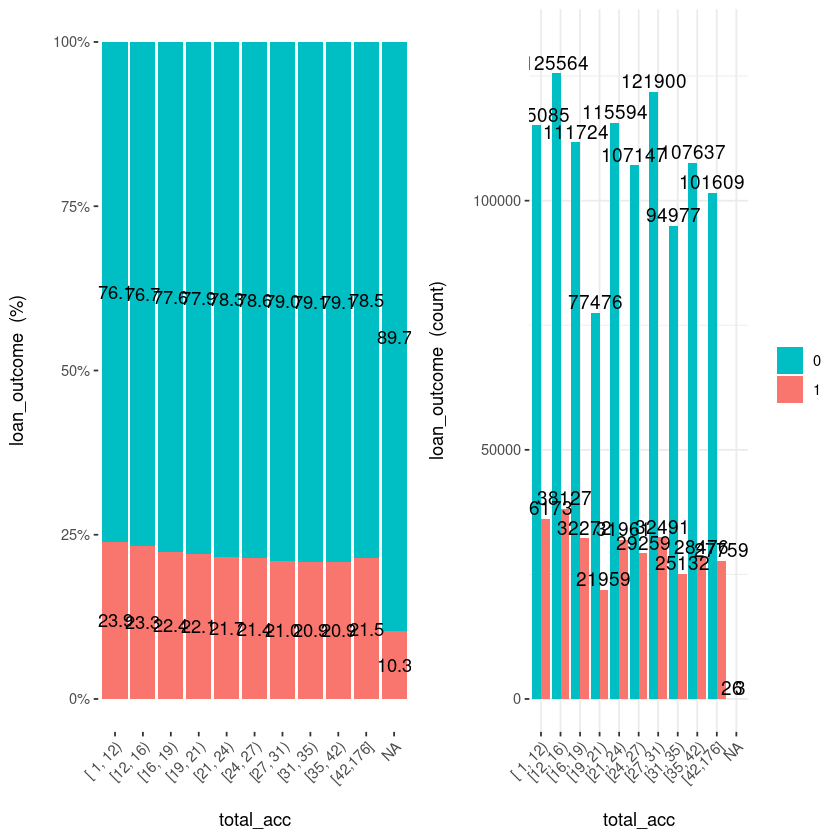

In [91]:
# Cross Plot 'total_acc' vs 'loan_outcome'
cross_plot(dt, input='total_acc', target='loan_outcome')

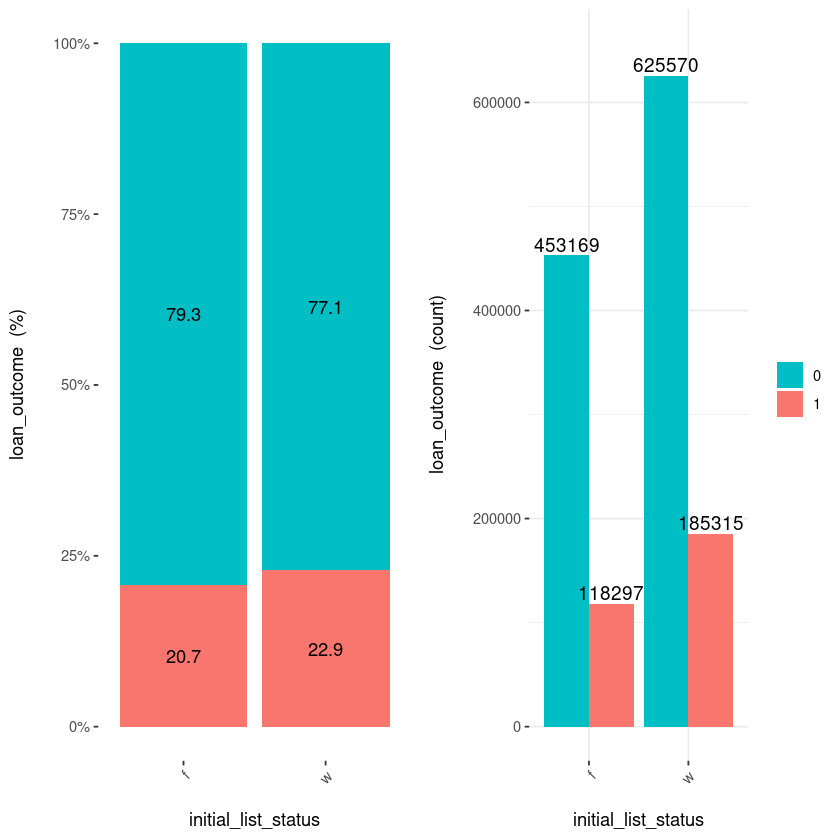

In [92]:
# Cross Plot 'initial_list_status' vs 'loan_outcome'
cross_plot(dt, input='initial_list_status', target='loan_outcome')

Plotting transformed variable 'last_pymnt_amnt' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



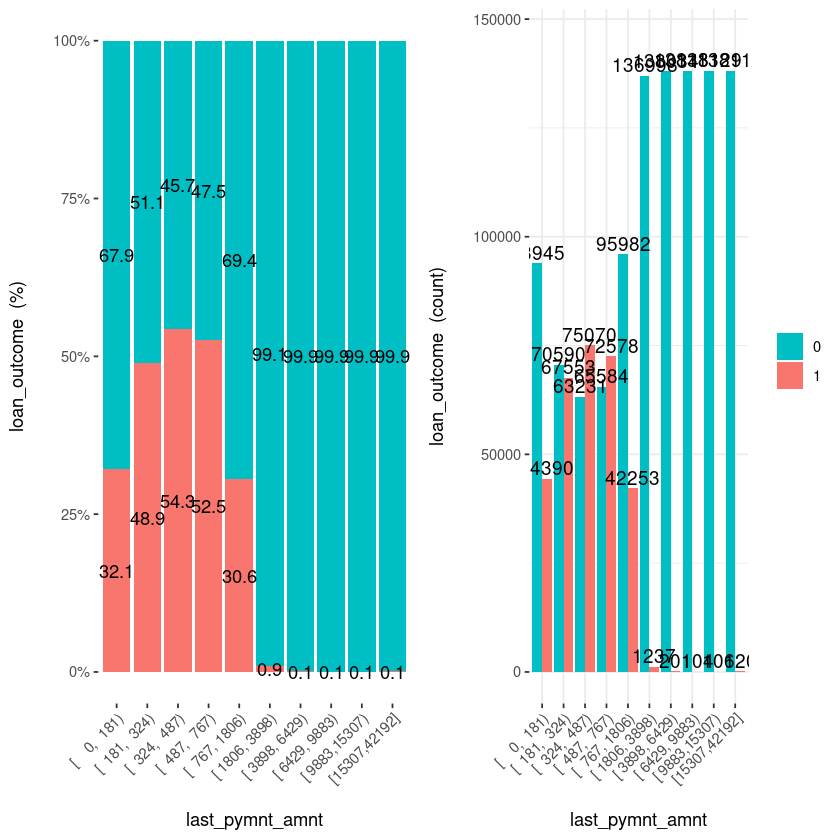

In [103]:
# Cross Plot 'last_pymnt_amnt' vs 'loan_outcome'
cross_plot(dt, input='last_pymnt_amnt', target='loan_outcome')

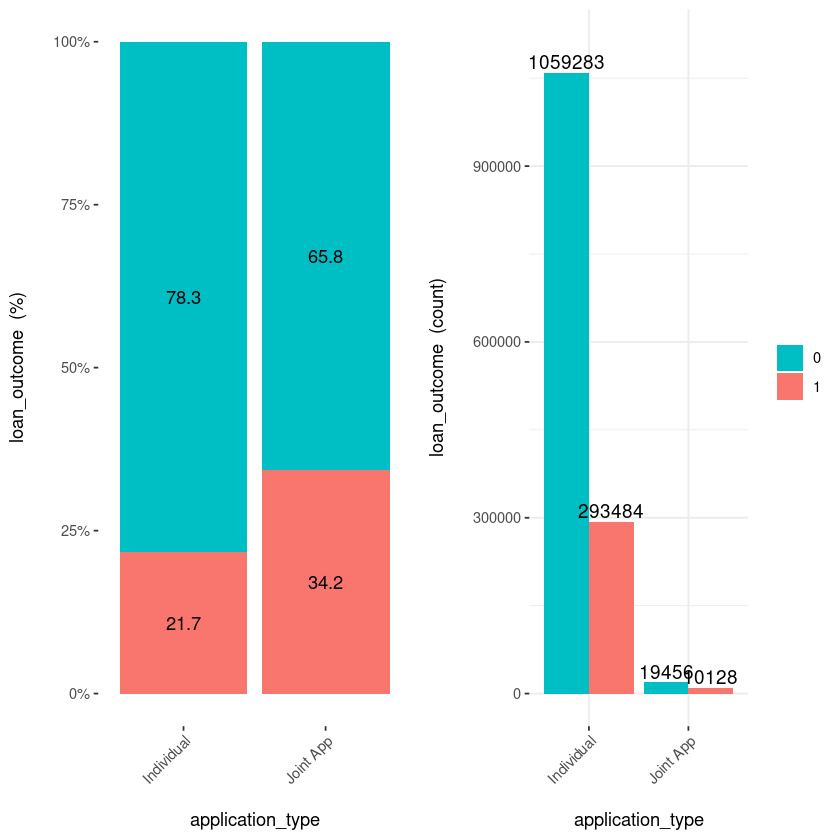

In [105]:
# Cross Plot 'application_type' vs 'loan_outcome'
cross_plot(dt, input='application_type', target='loan_outcome')

Plotting transformed variable 'tot_coll_amt' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



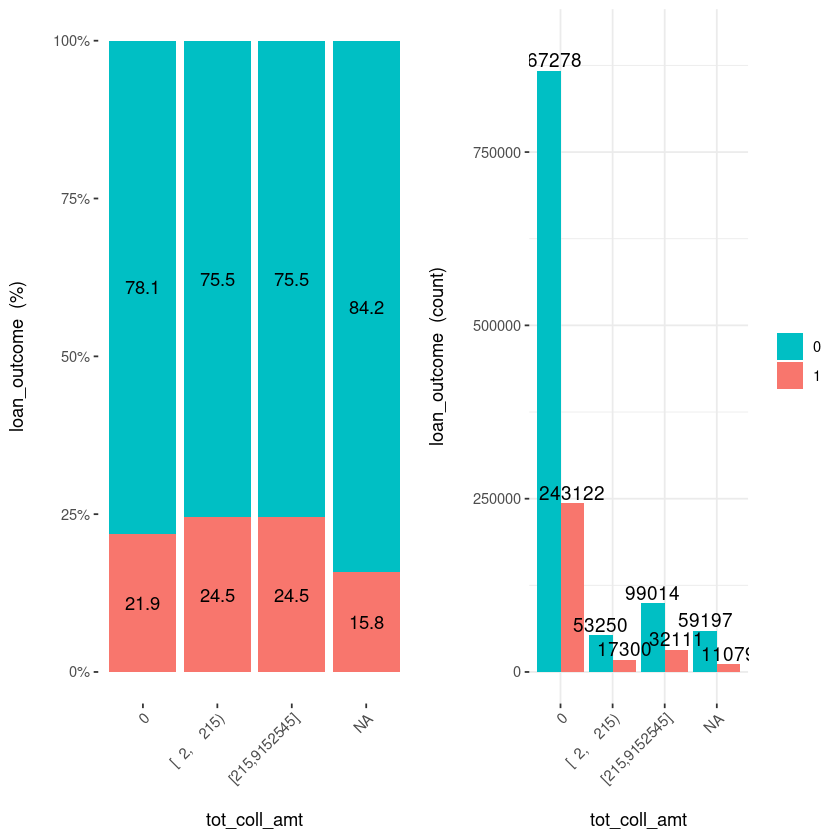

In [108]:
# Cross Plot 'tot_coll_amt' vs 'loan_outcome'
cross_plot(dt, input='tot_coll_amt', target='loan_outcome')

Plotting transformed variable 'tot_cur_bal' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



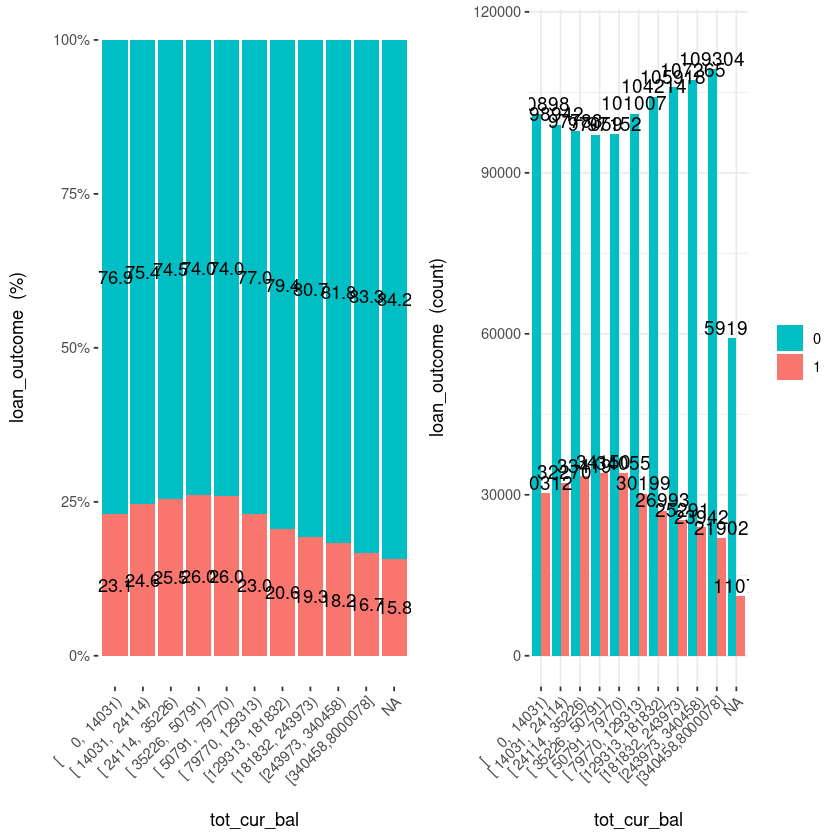

In [109]:
# Cross Plot 'tot_cur_bal' vs 'loan_outcome'
cross_plot(dt, input='tot_cur_bal', target='loan_outcome')

Plotting transformed variable 'total_rev_hi_lim' with 'equal_freq', (too many values). Disable with 'auto_binning=FALSE'



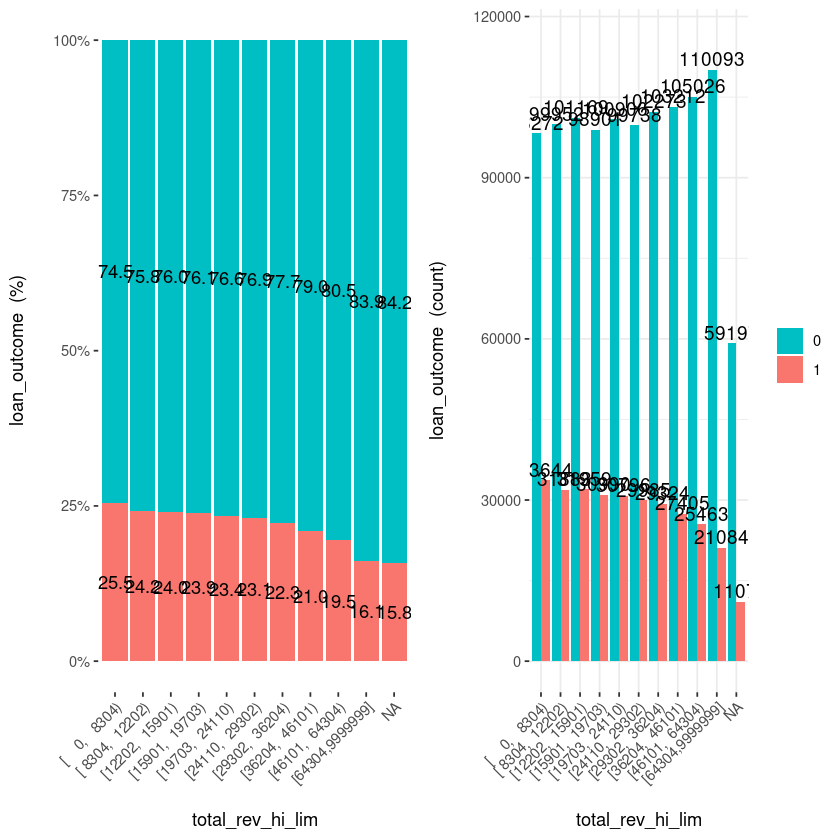

In [110]:
# Cross Plot 'total_rev_hi_lim' vs 'loan_outcome'
cross_plot(dt, input='total_rev_hi_lim', target='loan_outcome')

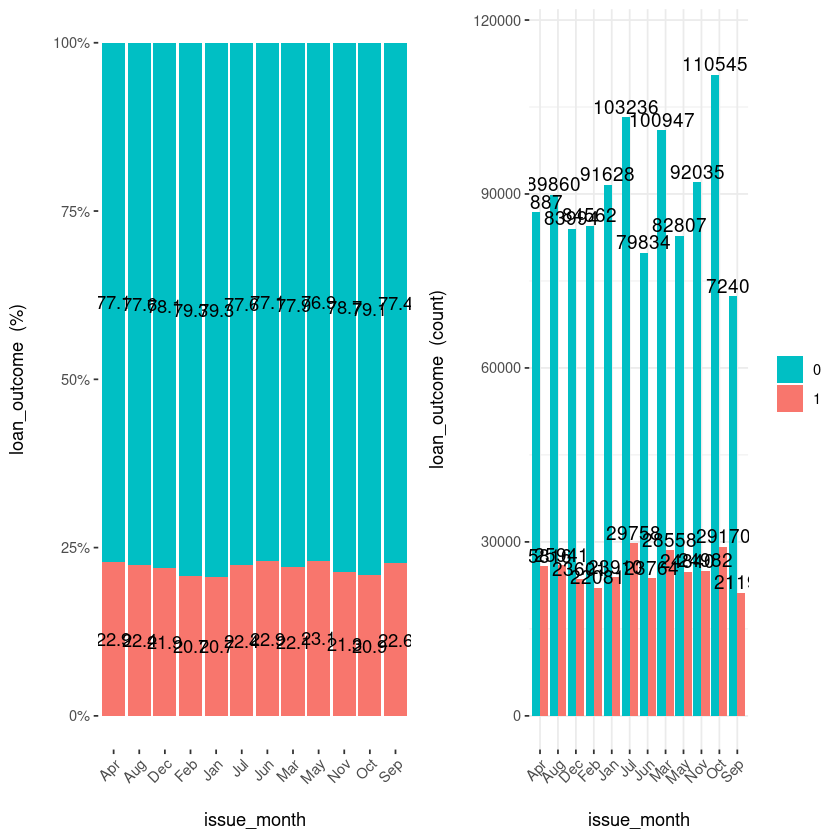

In [111]:
# Cross Plot 'issue_month' vs 'loan_outcome'
cross_plot(dt, input='issue_month', target='loan_outcome')

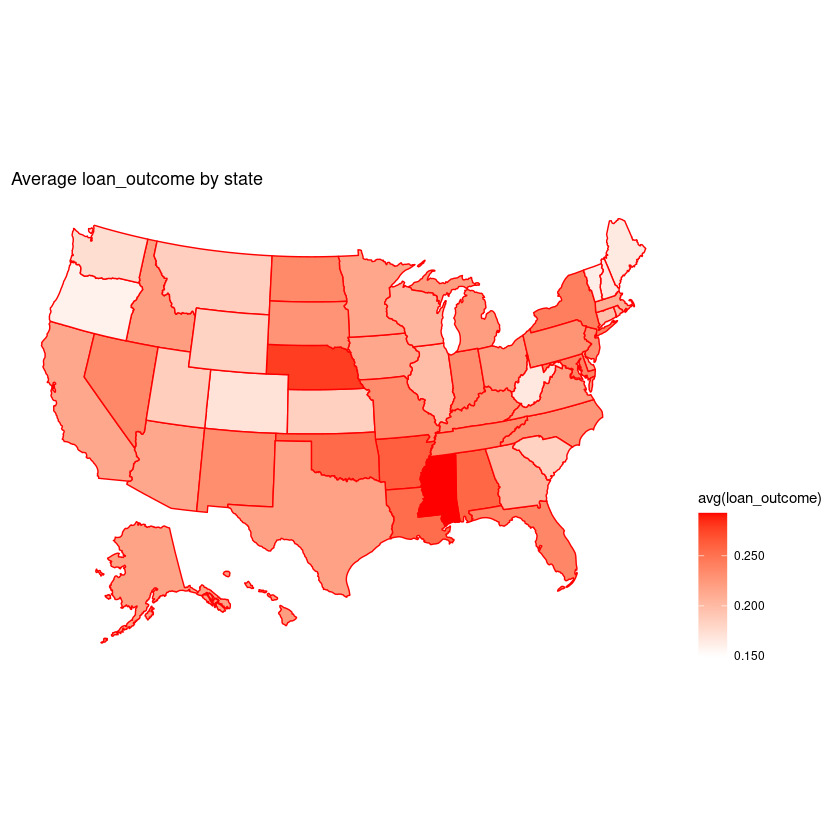

In [112]:
df_map=sqldf("select addr_state state, avg(loan_outcome)  avg_loan_outcome from dt group by addr_state")

plot_usmap(data = df_map, values = "avg_loan_outcome", color = "red") + 
  labs(title = "Average loan_outcome by state") +
  scale_fill_continuous(
    low = "white", high = "red", name = "avg(loan_outcome)", label = scales::comma
  ) + theme(legend.position = "right")

In [113]:
# Write CSV
fwrite(dt, "data/loan.csv.gz")